<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/ordergeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install esig

In [14]:
!pip install --upgrade numpy
!pip install --upgrade scipy

Experiment: Normal, i.i.d.
  Wasserstein distance (quantity): 0.797
  Wasserstein distance (price):    0.502
  L2 distance between signatures:   1907851385.760
--------------------------------------------------


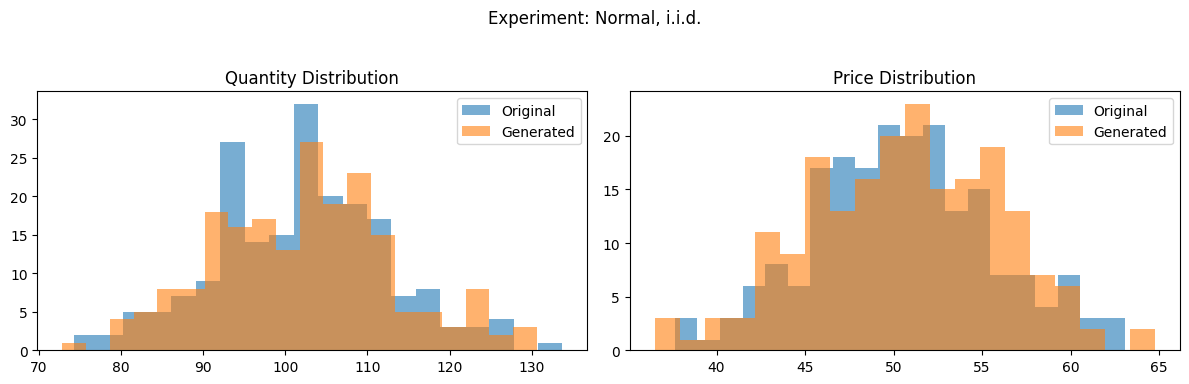

Experiment: Uniform, i.i.d.
  Wasserstein distance (quantity): 1.952
  Wasserstein distance (price):    0.247
  L2 distance between signatures:   167987618.171
--------------------------------------------------


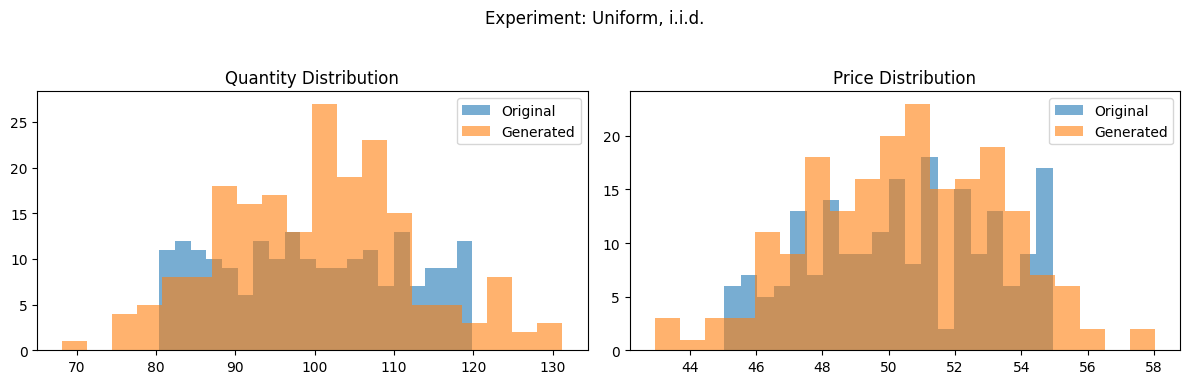

Experiment: Exponential, i.i.d.
  Wasserstein distance (quantity): 34.991
  Wasserstein distance (price):    19.849
  L2 distance between signatures:   168905891.634
--------------------------------------------------


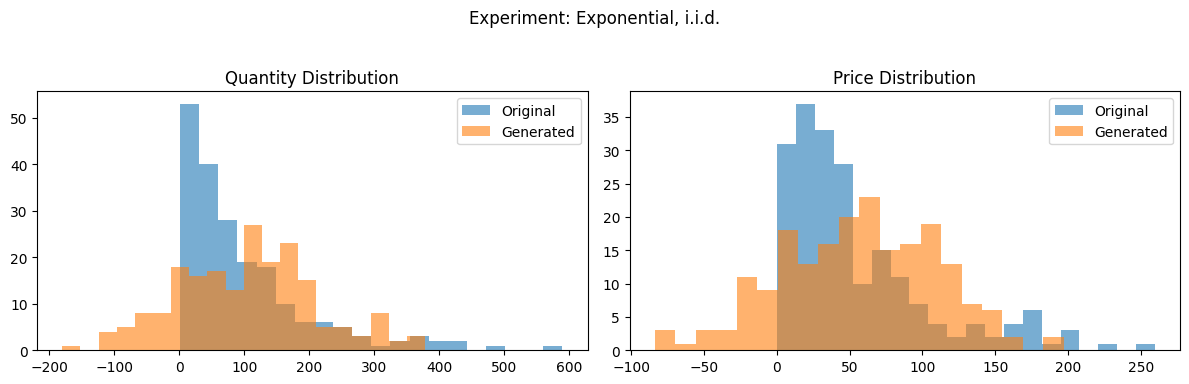

Experiment: Normal with serial correlation
  Wasserstein distance (quantity): 6.315
  Wasserstein distance (price):    3.597
  L2 distance between signatures:   1907868889.330
--------------------------------------------------


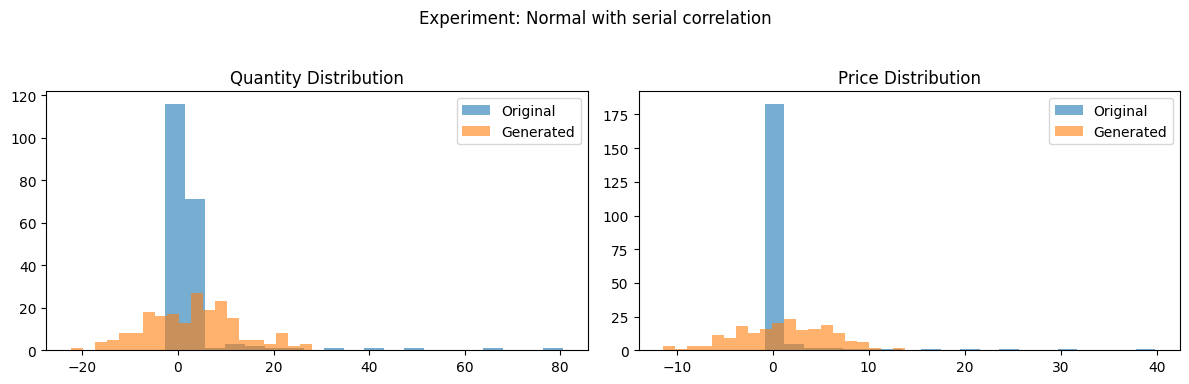

In [15]:
import numpy as np
import pandas as pd
import esig  # Make sure to install esig via pip install esig
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

def generate_random_orders(num_orders=100, distribution='normal', serial_corr=False, seed=None):
    """
    Generate a random orders dataframe with the following columns:
      - date, time, symbol, quantity, price, add, modify, delete.

    Parameters:
      num_orders (int): Number of orders to generate.
      distribution (str): Distribution for quantity/price. Options: 'normal', 'uniform', 'exponential'.
      serial_corr (bool): If True, simulate serial correlation (AR(1)) for quantity and price.
      seed (int): Optional seed for reproducibility.

    Returns:
      pd.DataFrame: DataFrame of orders.
    """
    if seed is not None:
        np.random.seed(seed)

    # Starting date and list of example symbols.
    start_date = pd.Timestamp('2025-01-01')
    symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

    # Lists to collect order attributes.
    dates = []
    times = []
    syms = []
    quantities = []
    prices = []
    adds = []
    modifies = []
    deletes = []

    # For serial correlation: initialize previous values and set AR coefficient.
    if serial_corr:
        q_prev = 100.0
        p_prev = 50.0
        rho = 0.8  # AR coefficient
    for i in range(num_orders):
        # Generate a random date within 30 days.
        rand_day = np.random.randint(0, 30)
        date = start_date + pd.Timedelta(days=rand_day)
        dates.append(date.date())

        # Generate a random time during the day (as a time object).
        seconds_in_day = np.random.randint(0, 24*60*60)
        time = pd.to_timedelta(seconds_in_day, unit='s')
        times.append((pd.Timestamp("2025-01-01") + time).time())

        # Choose a random symbol.
        sym = np.random.choice(symbols)
        syms.append(sym)

        # Generate quantity and price.
        if serial_corr:
            # Draw noise and then update via AR(1).
            if distribution == 'normal':
                noise_q = np.random.normal(loc=0, scale=5)
                noise_p = np.random.normal(loc=0, scale=1)
            elif distribution == 'uniform':
                noise_q = np.random.uniform(-5, 5)
                noise_p = np.random.uniform(-1, 1)
            elif distribution == 'exponential':
                noise_q = np.random.exponential(scale=5) - 5  # centered noise
                noise_p = np.random.exponential(scale=1) - 1
            else:
                noise_q = np.random.normal(loc=0, scale=5)
                noise_p = np.random.normal(loc=0, scale=1)
            q = rho * q_prev + (1 - rho) * noise_q
            p = rho * p_prev + (1 - rho) * noise_p
            q_prev = q
            p_prev = p
        else:
            # Independent draws.
            if distribution == 'normal':
                q = np.random.normal(loc=100, scale=10)
                p = np.random.normal(loc=50, scale=5)
            elif distribution == 'uniform':
                q = np.random.uniform(80, 120)
                p = np.random.uniform(45, 55)
            elif distribution == 'exponential':
                q = np.random.exponential(scale=100)
                p = np.random.exponential(scale=50)
            else:
                q = np.random.normal(loc=100, scale=10)
                p = np.random.normal(loc=50, scale=5)

        quantities.append(q)
        prices.append(p)

        # Randomly assign an operation: exactly one of add, modify, delete is set to 1.
        op = np.random.choice(['add', 'modify', 'delete'])
        adds.append(1 if op == 'add' else 0)
        modifies.append(1 if op == 'modify' else 0)
        deletes.append(1 if op == 'delete' else 0)

    df = pd.DataFrame({
        'date': dates,
        'time': times,
        'symbol': syms,
        'quantity': quantities,
        'price': prices,
        'add': adds,
        'modify': modifies,
        'delete': deletes
    })
    return df

def compute_order_signature(df, level=2):
    """
    Compute the signature of an order sequence using the esig package.

    The path is constructed from the following features:
      - time (converted to seconds from midnight)
      - symbol (encoded as an integer)
      - quantity, price, add, modify, delete.

    Parameters:
      df (pd.DataFrame): Orders dataframe.
      level (int): Truncation level of the signature.

    Returns:
      np.ndarray: Signature vector of the entire path.
    """
    # Convert time to seconds since midnight.
    times_sec = df['time'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second).to_numpy().reshape(-1, 1)

    # Encode symbol as an integer (based on sorted unique symbols).
    symbols_unique = sorted(df['symbol'].unique())
    sym_to_int = {sym: i for i, sym in enumerate(symbols_unique)}
    sym_int = df['symbol'].map(sym_to_int).to_numpy().reshape(-1, 1)

    # Get the other columns.
    quantity = df['quantity'].to_numpy().reshape(-1, 1)
    price = df['price'].to_numpy().reshape(-1, 1)
    add = df['add'].to_numpy().reshape(-1, 1)
    modify = df['modify'].to_numpy().reshape(-1, 1)
    delete = df['delete'].to_numpy().reshape(-1, 1)

    # Combine into a single path array.
    path = np.hstack([times_sec, sym_int, quantity, price, add, modify, delete])

    # Compute the signature using esig.
    sig = esig.stream2sig(path, level)
    return sig

def generate_orders_from_model(original_df, num_orders, seed=None):
    """
    Generate synthetic orders using a simple generative model.

    For continuous features (quantity and price) we fit a Gaussian model.
    For date, time, symbol, and operations we sample from the empirical distribution.

    Parameters:
      original_df (pd.DataFrame): Original orders dataframe.
      num_orders (int): Number of synthetic orders to generate.
      seed (int): Optional seed for reproducibility.

    Returns:
      pd.DataFrame: Generated orders dataframe.
    """
    if seed is not None:
        np.random.seed(seed)

    # Fit Gaussian for quantity and price.
    quantity_mean = original_df['quantity'].mean()
    quantity_std = original_df['quantity'].std()
    price_mean = original_df['price'].mean()
    price_std = original_df['price'].std()

    gen_quantity = np.random.normal(loc=quantity_mean, scale=quantity_std, size=num_orders)
    gen_price = np.random.normal(loc=price_mean, scale=price_std, size=num_orders)

    # Sample date and time from the original data.
    gen_date = np.random.choice(original_df['date'], size=num_orders)
    gen_time = np.random.choice(original_df['time'], size=num_orders)

    # Sample symbol from empirical distribution.
    gen_symbol = np.random.choice(original_df['symbol'], size=num_orders)

    # For operations, sample rows of the one-hot columns.
    operations = original_df[['add', 'modify', 'delete']].values
    op_indices = np.random.choice(len(operations), size=num_orders)
    gen_ops = operations[op_indices]
    gen_add = gen_ops[:, 0]
    gen_modify = gen_ops[:, 1]
    gen_delete = gen_ops[:, 2]

    gen_df = pd.DataFrame({
        'date': gen_date,
        'time': gen_time,
        'symbol': gen_symbol,
        'quantity': gen_quantity,
        'price': gen_price,
        'add': gen_add,
        'modify': gen_modify,
        'delete': gen_delete
    })
    return gen_df

def compute_wasserstein_distance(original_df, gen_df, column):
    """
    Compute the 1D Wasserstein distance between a continuous feature in the original
    and generated orders.

    Parameters:
      original_df (pd.DataFrame): Original orders.
      gen_df (pd.DataFrame): Generated orders.
      column (str): The column on which to compute the distance.

    Returns:
      float: Wasserstein distance.
    """
    return wasserstein_distance(original_df[column], gen_df[column])

if __name__ == "__main__":
    # Define the experiments.
    experiments = [
        {'name': 'Normal, i.i.d.', 'distribution': 'normal', 'serial_corr': False},
        {'name': 'Uniform, i.i.d.', 'distribution': 'uniform', 'serial_corr': False},
        {'name': 'Exponential, i.i.d.', 'distribution': 'exponential', 'serial_corr': False},
        {'name': 'Normal with serial correlation', 'distribution': 'normal', 'serial_corr': True},
    ]

    num_orders = 200  # number of orders per experiment
    sig_level = 2     # signature truncation level

    # Loop through experiments.
    for exp in experiments:
        print("Experiment:", exp['name'])
        # Generate original orders.
        orig_df = generate_random_orders(num_orders=num_orders,
                                         distribution=exp['distribution'],
                                         serial_corr=exp['serial_corr'],
                                         seed=42)

        # Compute signature of the original orders.
        orig_sig = compute_order_signature(orig_df, level=sig_level)

        # Generate synthetic orders using our simple generative model.
        gen_df = generate_orders_from_model(orig_df, num_orders, seed=101)
        gen_sig = compute_order_signature(gen_df, level=sig_level)

        # Compute Wasserstein distances for continuous features.
        w_distance_quantity = compute_wasserstein_distance(orig_df, gen_df, 'quantity')
        w_distance_price = compute_wasserstein_distance(orig_df, gen_df, 'price')

        # Compute L2 distance between the signature vectors.
        sig_distance = np.linalg.norm(orig_sig - gen_sig)

        print(f"  Wasserstein distance (quantity): {w_distance_quantity:.3f}")
        print(f"  Wasserstein distance (price):    {w_distance_price:.3f}")
        print(f"  L2 distance between signatures:   {sig_distance:.3f}")
        print("-" * 50)

        # (Optional) Plot histograms to visually compare distributions.
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].hist(orig_df['quantity'], bins=20, alpha=0.6, label='Original')
        axes[0].hist(gen_df['quantity'], bins=20, alpha=0.6, label='Generated')
        axes[0].set_title("Quantity Distribution")
        axes[0].legend()

        axes[1].hist(orig_df['price'], bins=20, alpha=0.6, label='Original')
        axes[1].hist(gen_df['price'], bins=20, alpha=0.6, label='Generated')
        axes[1].set_title("Price Distribution")
        axes[1].legend()

        plt.suptitle(f"Experiment: {exp['name']}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Experiment: Normal, i.i.d.
  Wasserstein distance (quantity): 0.630
  Wasserstein distance (price):    0.288
  L2 distance between signatures:   9861204375508.838
  TV distance (symbol distribution): 0.031
  TV distance (side distribution):   0.001
------------------------------------------------------------


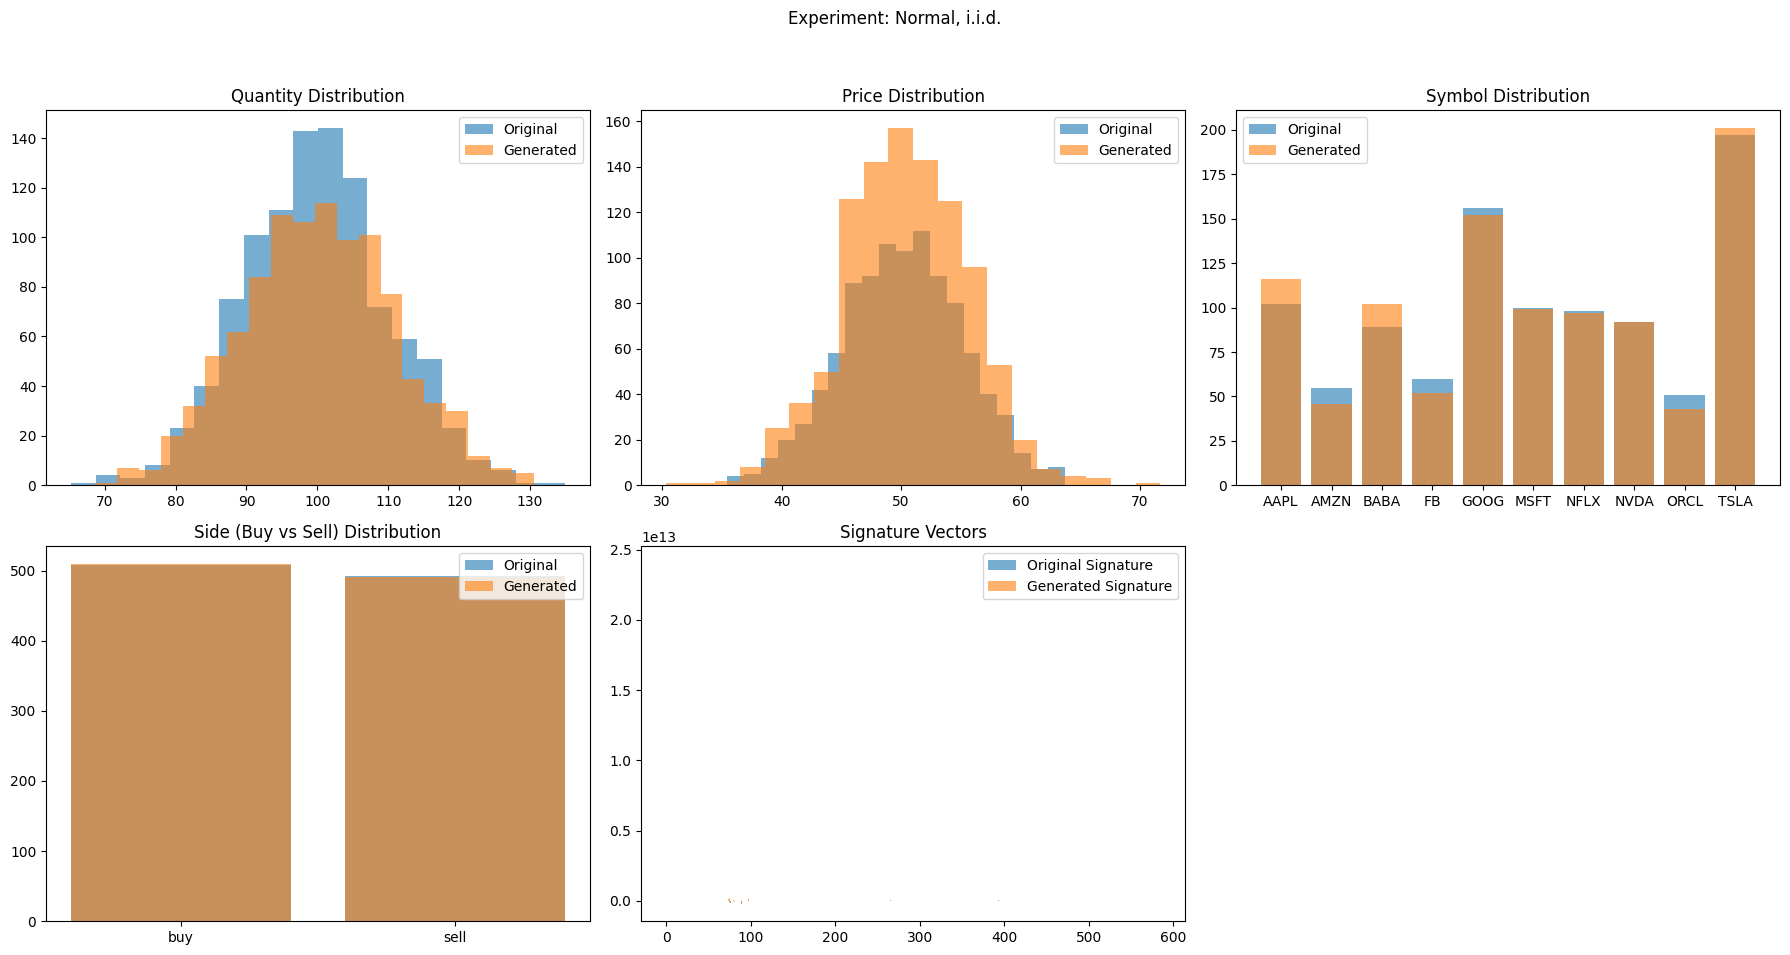

Experiment: Uniform, i.i.d.
  Wasserstein distance (quantity): 1.729
  Wasserstein distance (price):    0.433
  L2 distance between signatures:   49886639913187.828
  TV distance (symbol distribution): 0.038
  TV distance (side distribution):   0.006
------------------------------------------------------------


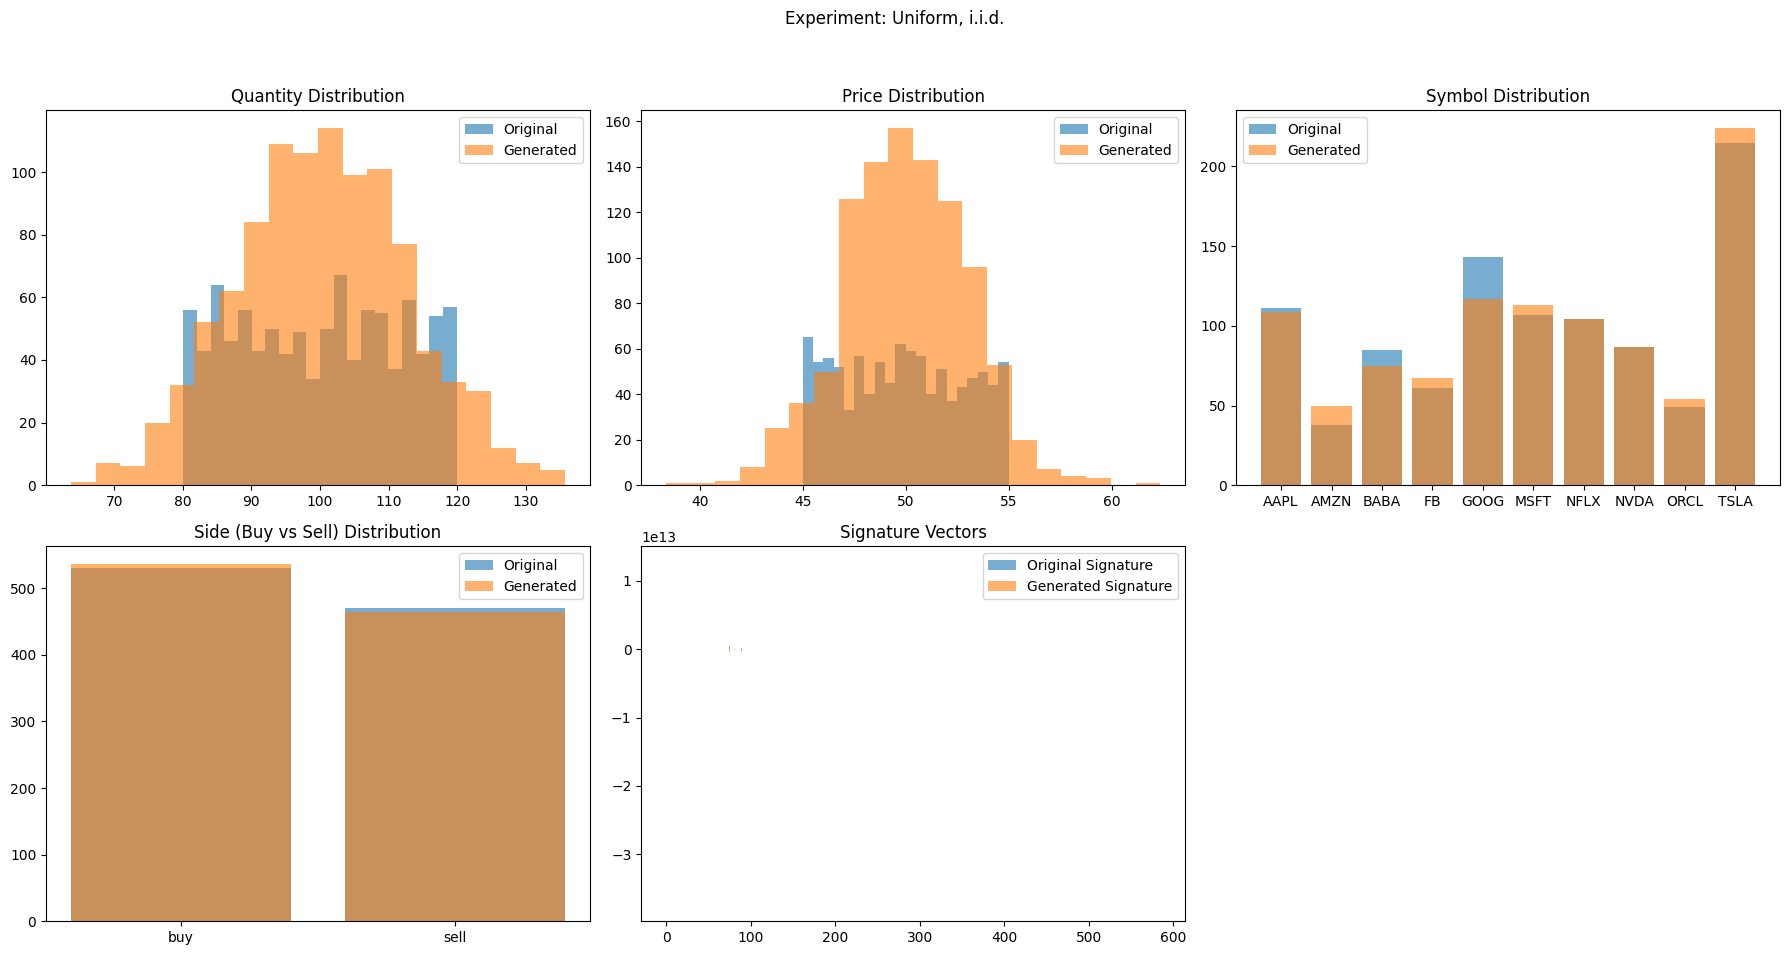

Experiment: Exponential, i.i.d.
  Wasserstein distance (quantity): 34.232
  Wasserstein distance (price):    19.668
  L2 distance between signatures:   50457188166088.297
  TV distance (symbol distribution): 0.038
  TV distance (side distribution):   0.006
------------------------------------------------------------


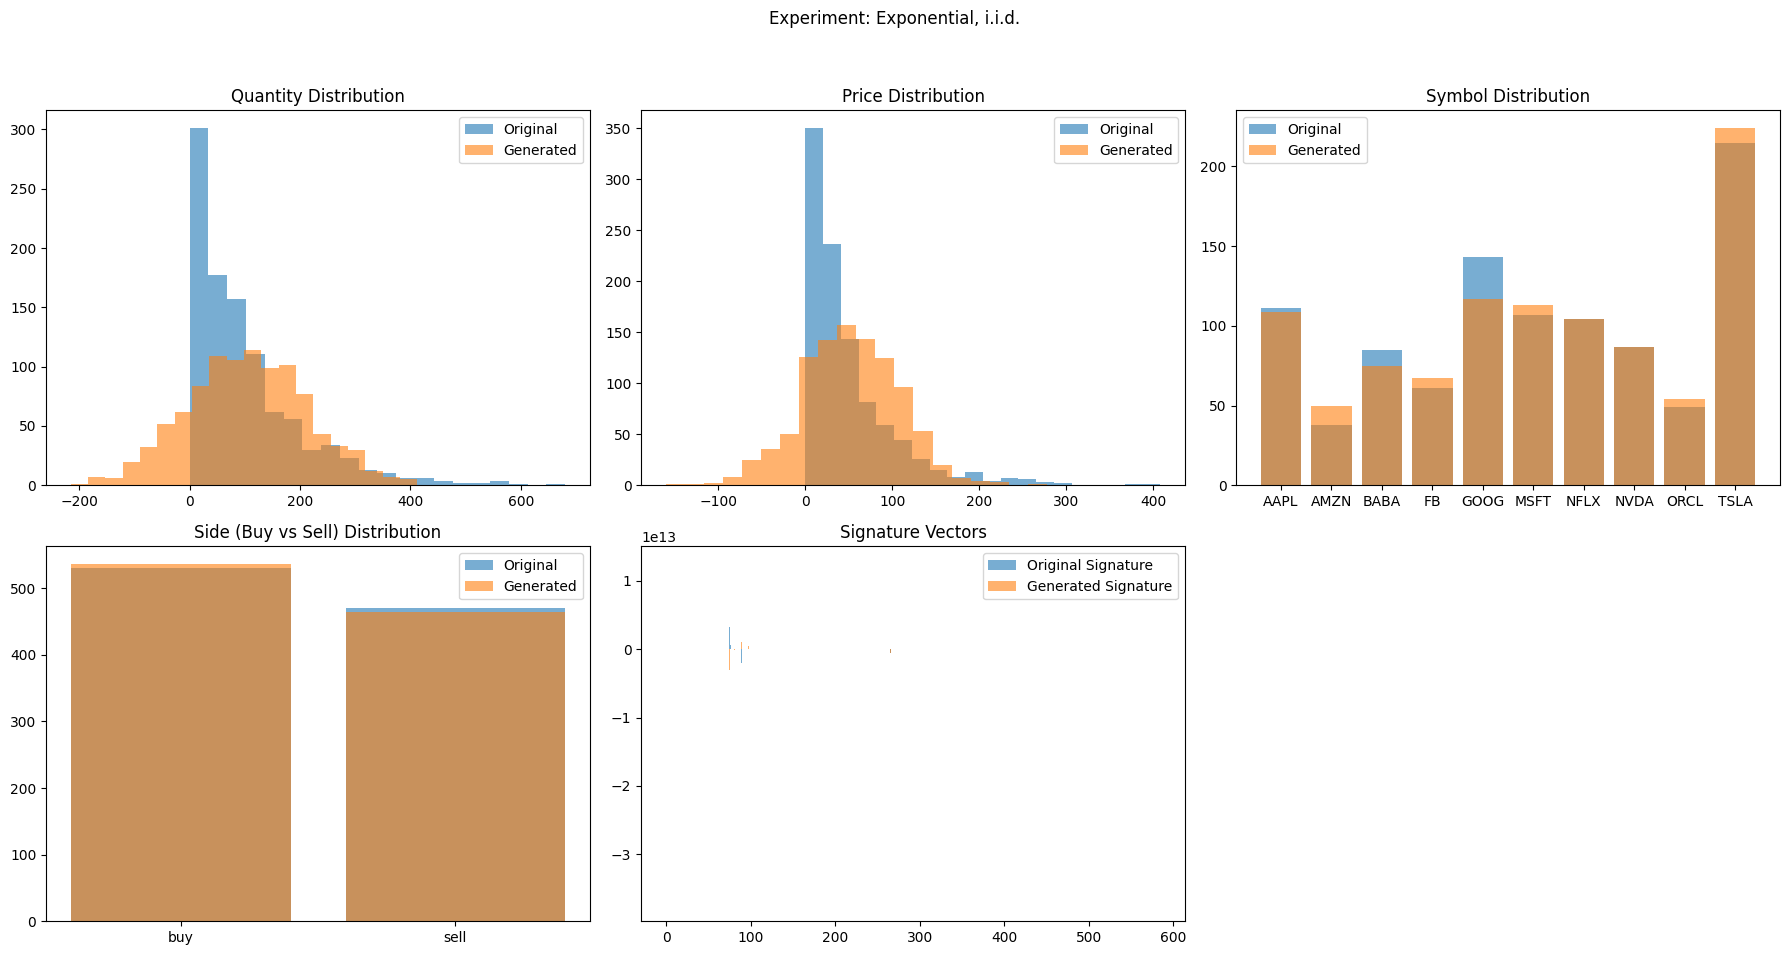

Experiment: Normal with serial correlation
  Wasserstein distance (quantity): 2.630
  Wasserstein distance (price):    1.514
  L2 distance between signatures:   9856183204901.279
  TV distance (symbol distribution): 0.031
  TV distance (side distribution):   0.001
------------------------------------------------------------


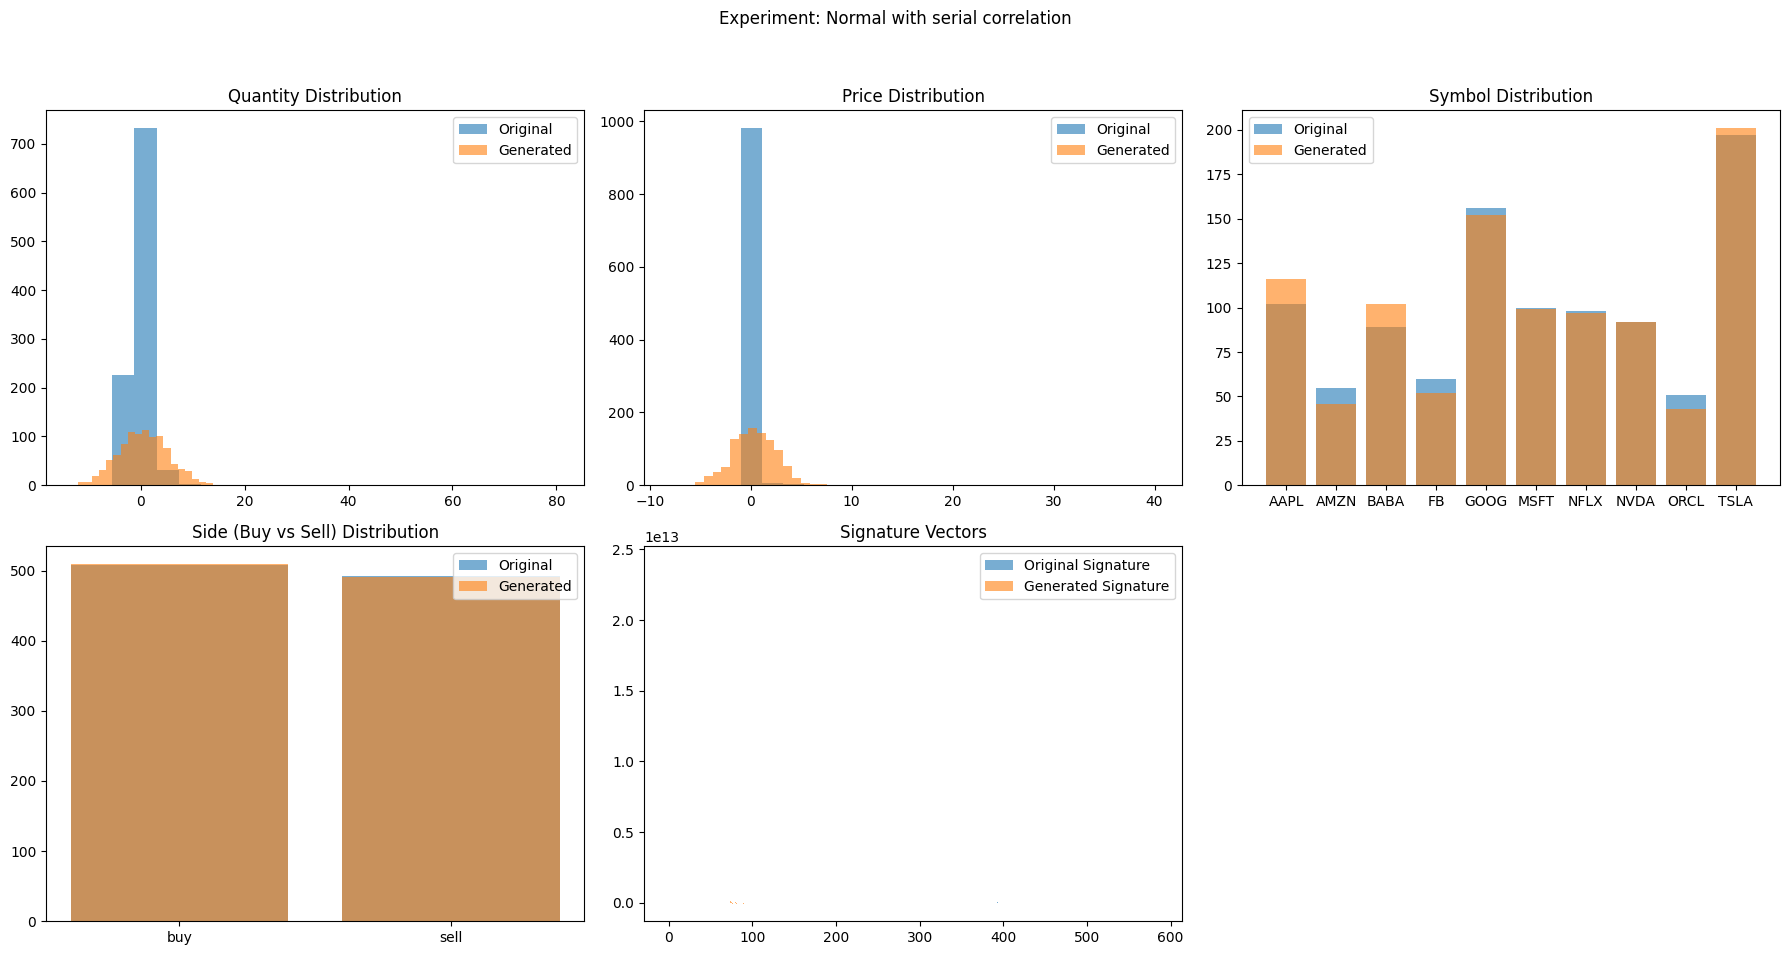

In [16]:
import numpy as np
import pandas as pd
import esig  # Make sure to install with: pip install esig
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

def generate_random_orders(num_orders=1000, distribution='normal', serial_corr=False, seed=None):
    """
    Generate a random orders dataframe with the following columns:
      - date, time, symbol, quantity, price, side, add, modify, delete.

    The symbol is chosen from 10 symbols with different probabilities.
    The side is randomly chosen as 'buy' or 'sell'.

    Parameters:
      num_orders (int): Number of orders to generate.
      distribution (str): Distribution for quantity/price. Options: 'normal', 'uniform', 'exponential'.
      serial_corr (bool): If True, simulate serial correlation (AR(1)) for quantity and price.
      seed (int): Optional seed for reproducibility.

    Returns:
      pd.DataFrame: DataFrame of orders.
    """
    if seed is not None:
        np.random.seed(seed)

    # Define a starting date.
    start_date = pd.Timestamp('2025-01-01')

    # Define 10 symbols with custom probabilities.
    symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA', 'NFLX', 'FB', 'NVDA', 'BABA', 'ORCL']
    symbol_probs = [0.1, 0.15, 0.1, 0.05, 0.2, 0.1, 0.05, 0.1, 0.1, 0.05]

    # Lists to collect order attributes.
    dates = []
    times = []
    syms = []
    quantities = []
    prices = []
    sides = []
    adds = []
    modifies = []
    deletes = []

    # For serial correlation: initialize previous values and set an AR coefficient.
    if serial_corr:
        q_prev = 100.0
        p_prev = 50.0
        rho = 0.8  # AR coefficient

    for i in range(num_orders):
        # Generate a random date within 30 days.
        rand_day = np.random.randint(0, 30)
        date = start_date + pd.Timedelta(days=rand_day)
        dates.append(date.date())

        # Generate a random time during the day.
        seconds_in_day = np.random.randint(0, 24*60*60)
        time_delta = pd.to_timedelta(seconds_in_day, unit='s')
        times.append((pd.Timestamp("2025-01-01") + time_delta).time())

        # Choose a symbol from 10 symbols with custom probability.
        sym = np.random.choice(symbols, p=symbol_probs)
        syms.append(sym)

        # Generate quantity and price.
        if serial_corr:
            # Use an AR(1) process.
            if distribution == 'normal':
                noise_q = np.random.normal(loc=0, scale=5)
                noise_p = np.random.normal(loc=0, scale=1)
            elif distribution == 'uniform':
                noise_q = np.random.uniform(-5, 5)
                noise_p = np.random.uniform(-1, 1)
            elif distribution == 'exponential':
                noise_q = np.random.exponential(scale=5) - 5
                noise_p = np.random.exponential(scale=1) - 1
            else:
                noise_q = np.random.normal(loc=0, scale=5)
                noise_p = np.random.normal(loc=0, scale=1)
            q = rho * q_prev + (1 - rho) * noise_q
            p = rho * p_prev + (1 - rho) * noise_p
            q_prev = q
            p_prev = p
        else:
            if distribution == 'normal':
                q = np.random.normal(loc=100, scale=10)
                p = np.random.normal(loc=50, scale=5)
            elif distribution == 'uniform':
                q = np.random.uniform(80, 120)
                p = np.random.uniform(45, 55)
            elif distribution == 'exponential':
                q = np.random.exponential(scale=100)
                p = np.random.exponential(scale=50)
            else:
                q = np.random.normal(loc=100, scale=10)
                p = np.random.normal(loc=50, scale=5)

        quantities.append(q)
        prices.append(p)

        # Randomly assign a side: 'buy' or 'sell'.
        side = np.random.choice(['buy', 'sell'])
        sides.append(side)

        # Randomly assign an operation: exactly one of add, modify, delete is set to 1.
        op = np.random.choice(['add', 'modify', 'delete'])
        adds.append(1 if op == 'add' else 0)
        modifies.append(1 if op == 'modify' else 0)
        deletes.append(1 if op == 'delete' else 0)

    df = pd.DataFrame({
        'date': dates,
        'time': times,
        'symbol': syms,
        'quantity': quantities,
        'price': prices,
        'side': sides,
        'add': adds,
        'modify': modifies,
        'delete': deletes
    })
    return df

def compute_order_signature(df, level=2):
    """
    Compute the signature of an order sequence using the esig package.

    The path is constructed from the following features:
      - time (converted to seconds from midnight)
      - symbol (encoded as an integer)
      - quantity, price, side (mapped to binary: buy=1, sell=0), add, modify, delete.

    Parameters:
      df (pd.DataFrame): Orders dataframe.
      level (int): Truncation level for the signature.

    Returns:
      np.ndarray: Signature vector of the order sequence.
    """
    # Convert time to seconds.
    times_sec = df['time'].apply(lambda t: t.hour*3600 + t.minute*60 + t.second).to_numpy().reshape(-1, 1)

    # Encode symbol as an integer.
    symbols_unique = sorted(df['symbol'].unique())
    sym_to_int = {sym: i for i, sym in enumerate(symbols_unique)}
    sym_int = df['symbol'].map(sym_to_int).to_numpy().reshape(-1, 1)

    # Continuous columns.
    quantity = df['quantity'].to_numpy().reshape(-1, 1)
    price = df['price'].to_numpy().reshape(-1, 1)

    # Encode side: buy -> 1, sell -> 0.
    side = df['side'].map({'buy': 1, 'sell': 0}).to_numpy().reshape(-1, 1)

    # Operation columns.
    add = df['add'].to_numpy().reshape(-1, 1)
    modify = df['modify'].to_numpy().reshape(-1, 1)
    delete = df['delete'].to_numpy().reshape(-1, 1)

    # Combine all features into a single path.
    path = np.hstack([times_sec, sym_int, quantity, price, side, add, modify, delete])

    # Compute the truncated signature.
    sig = esig.stream2sig(path, level)
    return sig

def generate_orders_from_model(original_df, num_orders, seed=None):
    """
    Generate synthetic orders using a simple generative model.

    Continuous features (quantity and price) are generated by fitting a Gaussian model,
    and the remaining categorical fields (date, time, symbol, side, and operations) are sampled
    from the empirical distribution.

    Parameters:
      original_df (pd.DataFrame): Original orders dataframe.
      num_orders (int): Number of synthetic orders to generate.
      seed (int): Optional seed for reproducibility.

    Returns:
      pd.DataFrame: Generated orders dataframe.
    """
    if seed is not None:
        np.random.seed(seed)

    # Fit Gaussian models for quantity and price.
    quantity_mean = original_df['quantity'].mean()
    quantity_std = original_df['quantity'].std()
    price_mean = original_df['price'].mean()
    price_std = original_df['price'].std()

    gen_quantity = np.random.normal(loc=quantity_mean, scale=quantity_std, size=num_orders)
    gen_price = np.random.normal(loc=price_mean, scale=price_std, size=num_orders)

    # Sample the categorical fields from the original distribution.
    gen_date = np.random.choice(original_df['date'], size=num_orders)
    gen_time = np.random.choice(original_df['time'], size=num_orders)
    gen_symbol = np.random.choice(original_df['symbol'], size=num_orders)
    gen_side = np.random.choice(original_df['side'], size=num_orders)

    # Sample the operations.
    operations = original_df[['add', 'modify', 'delete']].values
    op_indices = np.random.choice(len(operations), size=num_orders)
    gen_ops = operations[op_indices]
    gen_add = gen_ops[:, 0]
    gen_modify = gen_ops[:, 1]
    gen_delete = gen_ops[:, 2]

    gen_df = pd.DataFrame({
        'date': gen_date,
        'time': gen_time,
        'symbol': gen_symbol,
        'quantity': gen_quantity,
        'price': gen_price,
        'side': gen_side,
        'add': gen_add,
        'modify': gen_modify,
        'delete': gen_delete
    })
    return gen_df

def compute_wasserstein_distance(original_df, gen_df, column):
    """
    Compute the 1D Wasserstein distance between a continuous feature in the original
    and generated orders.

    Parameters:
      original_df (pd.DataFrame): Original orders.
      gen_df (pd.DataFrame): Generated orders.
      column (str): Column name to compare.

    Returns:
      float: Wasserstein distance.
    """
    return wasserstein_distance(original_df[column], gen_df[column])

def compute_total_variation_distance(orig_series, gen_series):
    """
    Compute the Total Variation (TV) distance between two categorical distributions.

    Parameters:
      orig_series (pd.Series): Original categorical data.
      gen_series (pd.Series): Generated categorical data.

    Returns:
      float: Total variation distance.
    """
    orig_counts = orig_series.value_counts(normalize=True).sort_index()
    gen_counts = gen_series.value_counts(normalize=True).sort_index()
    all_categories = set(orig_counts.index).union(set(gen_counts.index))
    orig_probs = np.array([orig_counts.get(cat, 0) for cat in all_categories])
    gen_probs = np.array([gen_counts.get(cat, 0) for cat in all_categories])
    tv_distance = 0.5 * np.sum(np.abs(orig_probs - gen_probs))
    return tv_distance

if __name__ == "__main__":
    # Define experiments with various distributions and with/without serial correlation.
    experiments = [
        {'name': 'Normal, i.i.d.', 'distribution': 'normal', 'serial_corr': False},
        {'name': 'Uniform, i.i.d.', 'distribution': 'uniform', 'serial_corr': False},
        {'name': 'Exponential, i.i.d.', 'distribution': 'exponential', 'serial_corr': False},
        {'name': 'Normal with serial correlation', 'distribution': 'normal', 'serial_corr': True},
    ]

    num_orders = 1000  # Many more orders
    sig_level = 3     # Truncation level for the signature

    for exp in experiments:
        print("Experiment:", exp['name'])
        # Generate the original orders.
        orig_df = generate_random_orders(num_orders=num_orders,
                                         distribution=exp['distribution'],
                                         serial_corr=exp['serial_corr'],
                                         seed=42)

        # Compute the signature of the original orders.
        orig_sig = compute_order_signature(orig_df, level=sig_level)

        # Generate synthetic orders.
        gen_df = generate_orders_from_model(orig_df, num_orders=num_orders, seed=101)
        gen_sig = compute_order_signature(gen_df, level=sig_level)

        # Compare continuous features (quantity and price) using Wasserstein distance.
        w_distance_quantity = compute_wasserstein_distance(orig_df, gen_df, 'quantity')
        w_distance_price = compute_wasserstein_distance(orig_df, gen_df, 'price')

        # Compare the overall signature vectors.
        sig_distance = np.linalg.norm(orig_sig - gen_sig)

        # Compare categorical distributions using total variation distance.
        tv_symbol = compute_total_variation_distance(orig_df['symbol'], gen_df['symbol'])
        tv_side   = compute_total_variation_distance(orig_df['side'], gen_df['side'])

        print(f"  Wasserstein distance (quantity): {w_distance_quantity:.3f}")
        print(f"  Wasserstein distance (price):    {w_distance_price:.3f}")
        print(f"  L2 distance between signatures:   {sig_distance:.3f}")
        print(f"  TV distance (symbol distribution): {tv_symbol:.3f}")
        print(f"  TV distance (side distribution):   {tv_side:.3f}")
        print("-" * 60)

        # (Optional) Plot histograms for visual comparison.
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        axes[0].hist(orig_df['quantity'], bins=20, alpha=0.6, label='Original')
        axes[0].hist(gen_df['quantity'], bins=20, alpha=0.6, label='Generated')
        axes[0].set_title("Quantity Distribution")
        axes[0].legend()

        axes[1].hist(orig_df['price'], bins=20, alpha=0.6, label='Original')
        axes[1].hist(gen_df['price'], bins=20, alpha=0.6, label='Generated')
        axes[1].set_title("Price Distribution")
        axes[1].legend()

        # Symbol distribution.
        orig_symbol_counts = orig_df['symbol'].value_counts().sort_index()
        gen_symbol_counts = gen_df['symbol'].value_counts().sort_index()
        axes[2].bar(orig_symbol_counts.index, orig_symbol_counts.values, alpha=0.6, label='Original')
        axes[2].bar(gen_symbol_counts.index, gen_symbol_counts.values, alpha=0.6, label='Generated')
        axes[2].set_title("Symbol Distribution")
        axes[2].legend()

        # Side (buy vs sell) distribution.
        orig_side_counts = orig_df['side'].value_counts().sort_index()
        gen_side_counts = gen_df['side'].value_counts().sort_index()
        axes[3].bar(orig_side_counts.index, orig_side_counts.values, alpha=0.6, label='Original')
        axes[3].bar(gen_side_counts.index, gen_side_counts.values, alpha=0.6, label='Generated')
        axes[3].set_title("Side (Buy vs Sell) Distribution")
        axes[3].legend()

        # Plot the signature vectors (if dimensionality is not too high).
        axes[4].bar(range(len(orig_sig)), orig_sig, alpha=0.6, label='Original Signature')
        axes[4].bar(range(len(gen_sig)), gen_sig, alpha=0.6, label='Generated Signature')
        axes[4].set_title("Signature Vectors")
        axes[4].legend()

        # Hide any extra subplot.
        axes[5].axis('off')

        plt.suptitle(f"Experiment: {exp['name']}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [17]:
!pip install hmmlearn

In [19]:
def generate_orders_from_hmm(original_df, num_orders, hyperparams, seed=None):
    """
    Generate synthetic orders using a Gaussian HMM.

    Parameters:
      original_df (pd.DataFrame): The original orders DataFrame.
      num_orders (int): Number of synthetic orders to generate.
      hyperparams (dict): Hyperparameters for the HMM, e.g.,
          {
              'n_components': 4,
              'covariance_type': 'full'
          }
      seed (int, optional): Seed for reproducibility.

    Returns:
      pd.DataFrame: A DataFrame of generated orders.
      If an error occurs, prints an error message and returns None.
    """
    try:
        if seed is not None:
            np.random.seed(seed)
        # Define the list of symbols (e.g., SEC1 to SEC10)
        symbols = [f"SEC{i}" for i in range(1, 11)]
        # Encode the orders into a numeric array
        data = encode_orders(original_df, symbols)
        # Extract hyperparameters for the HMM
        n_components = hyperparams.get('n_components', 4)
        cov_type = hyperparams.get('covariance_type', 'full')
        # Initialize and fit the HMM model
        model = GaussianHMM(n_components=n_components, covariance_type=cov_type,
                            random_state=seed, n_iter=100)
        model.fit(data)
        # Sample a new sequence of orders from the HMM
        gen_matrix, _ = model.sample(num_orders)
        # Decode the generated numeric data back into a DataFrame
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_hmm:", e)
        return None

In [22]:
import numpy as np
import pandas as pd
import esig  # pip install esig
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import itertools
import time

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For HMM
from hmmlearn.hmm import GaussianHMM

#########################################
# Data generation, encoding/decoding and evaluation functions
#########################################

def generate_random_orders(num_orders=1000, distribution='normal', serial_corr=False, seed=None,
                           buy_prob=0.5, side_corr_lag=5, side_corr_prob=0.0,
                           symbol_probs=None):
    try:
        if seed is not None:
            np.random.seed(seed)

        start_date = pd.Timestamp('2025-01-01')
        symbols = [f"SEC{i}" for i in range(1, 11)]
        if symbol_probs is None:
            symbol_probs = [1/10] * 10
        else:
            total = sum(symbol_probs)
            symbol_probs = [p/total for p in symbol_probs]

        dates, times, syms = [], [], []
        quantities, prices = [], []
        sides = []
        adds, modifies, deletes = [], [], []

        if serial_corr:
            q_prev, p_prev, rho = 100.0, 50.0, 0.8

        # To enforce lag correlation on the side feature.
        last_sides = {sym: [] for sym in symbols}

        for i in range(num_orders):
            rand_day = np.random.randint(0, 30)
            current_date = start_date + pd.Timedelta(days=rand_day)
            dates.append(current_date.date())

            seconds_in_day = np.random.randint(0, 24*60*60)
            tdelta = pd.to_timedelta(seconds_in_day, unit='s')
            times.append((pd.Timestamp("2025-01-01") + tdelta).time())

            sym = np.random.choice(symbols, p=symbol_probs)
            syms.append(sym)

            # Enforce side correlation if possible.
            if len(last_sides[sym]) >= side_corr_lag and np.random.rand() < side_corr_prob:
                side = last_sides[sym][-side_corr_lag]
            else:
                side = 'buy' if np.random.rand() < buy_prob else 'sell'
            sides.append(side)
            last_sides[sym].append(side)

            # Generate quantity and price.
            if serial_corr:
                if distribution == 'normal':
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                elif distribution == 'uniform':
                    noise_q = np.random.uniform(-5, 5)
                    noise_p = np.random.uniform(-1, 1)
                elif distribution == 'exponential':
                    noise_q = np.random.exponential(5) - 5
                    noise_p = np.random.exponential(1) - 1
                else:
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                q = rho * q_prev + (1 - rho) * noise_q
                p = rho * p_prev + (1 - rho) * noise_p
                q_prev, p_prev = q, p
            else:
                if distribution == 'normal':
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
                elif distribution == 'uniform':
                    q = np.random.uniform(80, 120)
                    p = np.random.uniform(45, 55)
                elif distribution == 'exponential':
                    q = np.random.exponential(100)
                    p = np.random.exponential(50)
                else:
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
            quantities.append(q)
            prices.append(p)

            # Randomly assign one operation flag.
            op = np.random.choice(['add', 'modify', 'delete'])
            adds.append(1 if op=='add' else 0)
            modifies.append(1 if op=='modify' else 0)
            deletes.append(1 if op=='delete' else 0)

        df = pd.DataFrame({
            'date': dates,
            'time': times,
            'symbol': syms,
            'quantity': quantities,
            'price': prices,
            'side': sides,
            'add': adds,
            'modify': modifies,
            'delete': deletes
        })
        return df
    except Exception as e:
        print("Error in generate_random_orders:", e)
        return pd.DataFrame()  # Return an empty DataFrame on error

import datetime

def compute_order_signature(df, level=2):
    try:
        # Helper function: if t is a string, parse it; otherwise, assume it's a time object.
        def get_seconds(t):
            if isinstance(t, str):
                try:
                    # Expecting format "HH:MM:SS"
                    t_obj = datetime.datetime.strptime(t, "%H:%M:%S").time()
                except Exception as e:
                    print("Error parsing time string:", t, e)
                    t_obj = datetime.time(0, 0, 0)
                return t_obj.hour * 3600 + t_obj.minute * 60 + t_obj.second
            else:
                return t.hour * 3600 + t.minute * 60 + t.second

        times_sec = df['time'].apply(lambda t: get_seconds(t)).to_numpy().reshape(-1, 1)
        symbols_unique = sorted(df['symbol'].unique())
        sym_to_int = {sym: i for i, sym in enumerate(symbols_unique)}
        sym_int = df['symbol'].map(sym_to_int).to_numpy().reshape(-1, 1)
        quantity = df['quantity'].to_numpy().reshape(-1, 1)
        price = df['price'].to_numpy().reshape(-1, 1)
        side = df['side'].map({'buy': 1, 'sell': 0}).to_numpy().reshape(-1, 1)
        add = df['add'].to_numpy().reshape(-1, 1)
        modify = df['modify'].to_numpy().reshape(-1, 1)
        delete = df['delete'].to_numpy().reshape(-1, 1)
        path = np.hstack([times_sec, sym_int, quantity, price, side, add, modify, delete])
        sig = esig.stream2sig(path, level)
        return sig
    except Exception as e:
        print("Error in compute_order_signature:", e)
        return np.array([])

def compute_wasserstein_distance(original_df, gen_df, column):
    try:
        return wasserstein_distance(original_df[column], gen_df[column])
    except Exception as e:
        print("Error in compute_wasserstein_distance:", e)
        return np.nan

def compute_total_variation_distance(orig_series, gen_series):
    try:
        orig_counts = orig_series.value_counts(normalize=True).sort_index()
        gen_counts = gen_series.value_counts(normalize=True).sort_index()
        all_categories = set(orig_counts.index).union(set(gen_counts.index))
        orig_probs = np.array([orig_counts.get(cat, 0) for cat in all_categories])
        gen_probs = np.array([gen_counts.get(cat, 0) for cat in all_categories])
        return 0.5 * np.sum(np.abs(orig_probs - gen_probs))
    except Exception as e:
        print("Error in compute_total_variation_distance:", e)
        return np.nan

def compute_side_lag_correlation(df, lag=5):
    try:
        correlations = []
        for sym in df['symbol'].unique():
            symbol_data = df[df['symbol'] == sym]
            side_numeric = symbol_data['side'].map({'buy': 1, 'sell': 0}).to_numpy()
            if len(side_numeric) > lag:
                correlations.append(np.mean(side_numeric[:-lag] == side_numeric[lag:]))
        return np.mean(correlations) if correlations else np.nan
    except Exception as e:
        print("Error in compute_side_lag_correlation:", e)
        return np.nan

def evaluate_generated_orders(original_df, gen_df, side_lag=5):
    try:
        metrics = {}
        metrics['wasserstein_quantity'] = compute_wasserstein_distance(original_df, gen_df, 'quantity')
        metrics['wasserstein_price'] = compute_wasserstein_distance(original_df, gen_df, 'price')
        metrics['tv_symbol'] = compute_total_variation_distance(original_df['symbol'], gen_df['symbol'])
        metrics['tv_side'] = compute_total_variation_distance(original_df['side'], gen_df['side'])
        orig_sig = compute_order_signature(original_df)
        gen_sig = compute_order_signature(gen_df)
        metrics['signature_distance'] = np.linalg.norm(orig_sig - gen_sig)
        metrics['side_lag_corr_original'] = compute_side_lag_correlation(original_df, lag=side_lag)
        metrics['side_lag_corr_generated'] = compute_side_lag_correlation(gen_df, lag=side_lag)
        metrics['side_lag_corr_diff'] = abs(metrics['side_lag_corr_original'] - metrics['side_lag_corr_generated'])
        metrics['overall'] = (metrics['wasserstein_quantity'] + metrics['wasserstein_price'] +
                              metrics['tv_symbol'] + metrics['tv_side'] +
                              metrics['signature_distance'] + metrics['side_lag_corr_diff'])
        return metrics
    except Exception as e:
        print("Error in evaluate_generated_orders:", e)
        return {}

#########################################
# Encoding/Decoding for sequence models
#########################################

def encode_order(row, symbols):
    try:
        vec = []
        # time: seconds since midnight
        t = row['time']
        vec.append(t.hour*3600 + t.minute*60 + t.second)
        # symbol: one-hot vector
        one_hot = [1 if row['symbol'] == s else 0 for s in symbols]
        vec.extend(one_hot)
        # quantity and price
        vec.append(row['quantity'])
        vec.append(row['price'])
        # side: 1 for buy, 0 for sell
        vec.append(1 if row['side'] == 'buy' else 0)
        # operations: add, modify, delete
        vec.append(row['add'])
        vec.append(row['modify'])
        vec.append(row['delete'])
        return np.array(vec, dtype=np.float32)
    except Exception as e:
        print("Error in encode_order:", e)
        return np.zeros(17, dtype=np.float32)

def encode_orders(df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1, 11)]
        encoded = df.apply(lambda row: encode_order(row, symbols), axis=1)
        return np.stack(encoded.to_numpy())
    except Exception as e:
        print("Error in encode_orders:", e)
        return np.zeros((len(df), 17), dtype=np.float32)

def decode_order(vector, original_df, symbols):
    try:
        seconds = vector[0]
        hour = int(seconds // 3600) % 24
        minute = int((seconds % 3600) // 60)
        second = int(seconds % 60)
        time_str = f"{hour:02d}:{minute:02d}:{second:02d}"
        sym_idx = np.argmax(vector[1:11])
        symbol = symbols[sym_idx]
        quantity = vector[11]
        price = vector[12]
        side = 'buy' if vector[13] >= 0.5 else 'sell'
        add = 1 if vector[14] >= 0.5 else 0
        modify = 1 if vector[15] >= 0.5 else 0
        delete = 1 if vector[16] >= 0.5 else 0
        return {'time': time_str, 'symbol': symbol, 'quantity': quantity,
                'price': price, 'side': side, 'add': add, 'modify': modify, 'delete': delete}
    except Exception as e:
        print("Error in decode_order:", e)
        return {'time': "00:00:00", 'symbol': symbols[0], 'quantity': 0, 'price': 0, 'side': 'buy', 'add': 0, 'modify': 0, 'delete': 0}

def decode_orders(matrix, original_df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1, 11)]
        orders = []
        dates = original_df['date'].to_numpy()  # sample date from original data
        for i, vec in enumerate(matrix):
            order = decode_order(vec, original_df, symbols)
            order['date'] = np.random.choice(dates)
            orders.append(order)
        return pd.DataFrame(orders)
    except Exception as e:
        print("Error in decode_orders:", e)
        return pd.DataFrame()

def prepare_sequence_data(data, seq_len):
    try:
        if len(data) <= seq_len:
            raise ValueError(f"Not enough data to prepare sequence: len(data)={len(data)} <= seq_len={seq_len}")
        X, Y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:i+seq_len])
            Y.append(data[i+seq_len])
        return np.array(X), np.array(Y)
    except Exception as e:
        print("Error in prepare_sequence_data:", e)
        return np.array([]), np.array([])

#########################################
# PyTorch LSTM generative model
#########################################

class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMGenerator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]    # use the last time-step
        out = self.fc(out)
        return out

def generate_orders_from_lstm(original_df, num_orders, hyperparams, seed=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1, 11)]
        data = encode_orders(original_df, symbols)  # shape: (N, feature_dim)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Sequence data is empty. Check seq_len and data length.")
        feature_dim = data.shape[1]
        hidden_size = hyperparams.get('num_units', 32)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model = LSTMGenerator(input_size=feature_dim, hidden_size=hidden_size, output_size=feature_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        # Generation: seed with the last sequence from training data.
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)  # shape: (1, seq_len, feature_dim)
                pred = model(inp)            # shape: (1, feature_dim)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                # Fix: do not unsqueeze pred here; it is already 2D.
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_lstm:", e)
        return None

#########################################
# PyTorch Transformer generative model
#########################################

class TransformerGenerator(nn.Module):
    def __init__(self, input_size, num_units, num_heads, num_layers=1):
        super(TransformerGenerator, self).__init__()
        self.input_proj = nn.Linear(input_size, num_units)
        encoder_layer = nn.TransformerEncoderLayer(d_model=num_units, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(num_units, input_size)

    def forward(self, x):
        x = self.input_proj(x)               # (batch, seq_len, num_units)
        x = self.transformer_encoder(x)        # (batch, seq_len, num_units)
        x = x[:, -1, :]                      # take the output at the last time-step
        x = self.fc(x)
        return x

def generate_orders_from_transformer(original_df, num_orders, hyperparams, seed=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1, 11)]
        data = encode_orders(original_df, symbols)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Sequence data is empty. Check seq_len and data length.")
        feature_dim = data.shape[1]
        num_units = hyperparams.get('num_units', 32)
        num_heads = hyperparams.get('num_heads', 2)
        num_layers = hyperparams.get('num_layers', 1)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model = TransformerGenerator(input_size=feature_dim, num_units=num_units,
                                     num_heads=num_heads, num_layers=num_layers)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        # Generation: seed with the last sequence.
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)  # shape: (1, seq_len, feature_dim)
                pred = model(inp)            # expected shape: (1, feature_dim)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                # Fix: do not unsqueeze pred here.
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_transformer:", e)
        return None

#########################################
# GAN generative model using PyTorch
#########################################

class Generator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def generate_orders_from_gan(original_df, num_orders, hyperparams, seed=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1, 11)]
        data = encode_orders(original_df, symbols)  # shape: (N, feature_dim)
        data_tensor = torch.tensor(data, dtype=torch.float32)
        input_dim = data.shape[1]

        noise_dim = hyperparams.get('noise_dim', 100)
        hidden_dim = hyperparams.get('hidden_dim', 64)
        epochs = hyperparams.get('epochs', 100)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)

        generator = Generator(noise_dim, hidden_dim, input_dim)
        discriminator = Discriminator(input_dim, hidden_dim)

        criterion = nn.BCELoss()
        optim_G = optim.Adam(generator.parameters(), lr=learning_rate)
        optim_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

        dataset = torch.utils.data.TensorDataset(data_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for real_batch, in dataloader:
                batch_size_curr = real_batch.size(0)
                real_labels = torch.ones(batch_size_curr, 1)
                fake_labels = torch.zeros(batch_size_curr, 1)

                optim_D.zero_grad()
                outputs_real = discriminator(real_batch)
                loss_real = criterion(outputs_real, real_labels)

                z = torch.randn(batch_size_curr, noise_dim)
                fake_data = generator(z)
                outputs_fake = discriminator(fake_data.detach())
                loss_fake = criterion(outputs_fake, fake_labels)

                loss_D = loss_real + loss_fake
                loss_D.backward()
                optim_D.step()

                optim_G.zero_grad()
                outputs_fake = discriminator(fake_data)
                loss_G = criterion(outputs_fake, real_labels)
                loss_G.backward()
                optim_G.step()

        generator.eval()
        with torch.no_grad():
            z = torch.randn(num_orders, noise_dim)
            gen_data = generator(z).cpu().numpy()
        gen_df = decode_orders(gen_data, original_df, symbols)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_gan:", e)
        return None

#########################################
# Baseline and “Mamba” generative models (modified to accept hyperparams)
#########################################

def generate_orders_from_baseline(original_df, num_orders, hyperparams=None, seed=None):
    try:
        if seed is not None:
            np.random.seed(seed)
        quantity_mean = original_df['quantity'].mean()
        quantity_std = original_df['quantity'].std()
        price_mean = original_df['price'].mean()
        price_std = original_df['price'].std()
        gen_quantity = np.random.normal(quantity_mean, quantity_std, num_orders)
        gen_price = np.random.normal(price_mean, price_std, num_orders)
        gen_date = np.random.choice(original_df['date'], size=num_orders)
        gen_time = np.random.choice(original_df['time'], size=num_orders)
        gen_symbol = np.random.choice(original_df['symbol'], size=num_orders)
        gen_side = np.random.choice(original_df['side'], size=num_orders)
        operations = original_df[['add','modify','delete']].values
        op_indices = np.random.choice(len(operations), size=num_orders)
        gen_ops = operations[op_indices]
        gen_add = gen_ops[:, 0]
        gen_modify = gen_ops[:, 1]
        gen_delete = gen_ops[:, 2]
        df = pd.DataFrame({
            'date': gen_date,
            'time': gen_time,
            'symbol': gen_symbol,
            'quantity': gen_quantity,
            'price': gen_price,
            'side': gen_side,
            'add': gen_add,
            'modify': gen_modify,
            'delete': gen_delete
        })
        return df
    except Exception as e:
        print("Error in generate_orders_from_baseline:", e)
        return None

def generate_orders_from_mamba(original_df, num_orders, hyperparams=None, seed=None):
    try:
        # Placeholder for Mamba model – here we reuse the baseline.
        return generate_orders_from_baseline(original_df, num_orders, hyperparams, seed=seed)
    except Exception as e:
        print("Error in generate_orders_from_mamba:", e)
        return None

#########################################
# Hyperparameter tuning helper
#########################################

def tune_model(model_func, original_df, num_orders, hyperparams_grid, seed=None):
    best_score = np.inf
    best_params = None
    best_metrics = None
    best_generated = None
    try:
        if not hyperparams_grid:
            try:
                gen_df = model_func(original_df, num_orders, {}, seed=seed)
                metrics = evaluate_generated_orders(original_df, gen_df)
                return {}, metrics, gen_df
            except Exception as e:
                print("Error in model_func call with empty hyperparameters:", e)
                return {}, None, None
        keys, values = zip(*hyperparams_grid.items())
        for combination in itertools.product(*values):
            params = dict(zip(keys, combination))
            try:
                gen_df = model_func(original_df, num_orders, params, seed=seed)
                if gen_df is None:
                    raise ValueError("Generated DataFrame is None")
                metrics = evaluate_generated_orders(original_df, gen_df)
                score = metrics.get('overall', np.inf)
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_metrics = metrics
                    best_generated = gen_df
            except Exception as e:
                print("Error with parameters", params, ":", e)
        if best_metrics is None:
            print("All hyperparameter combinations failed for model", model_func.__name__)
            return {}, None, None
        return best_params, best_metrics, best_generated
    except Exception as e:
        print("Error in tune_model:", e)
        return {}, None, None

#########################################
# Define hyperparameter grids for each model
#########################################

hp_grid_lstm = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005]
}

hp_grid_transformer = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'num_heads': [2, 4],
    'num_layers': [1, 2],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005]
}

hp_grid_hmm = {
    'n_components': [2, 4, 6],
    'covariance_type': ['full', 'diag']
}

hp_grid_gan = {
    'noise_dim': [100],
    'hidden_dim': [64, 128],
    'epochs': [50, 100],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005]
}

hp_grid_baseline = {}
hp_grid_mamba = {}

#########################################
# Dictionary of models to test
#########################################

models = [
    {'name': 'Baseline', 'func': generate_orders_from_baseline, 'hp_grid': hp_grid_baseline},
    {'name': 'LSTM', 'func': generate_orders_from_lstm, 'hp_grid': hp_grid_lstm},
    {'name': 'Transformer', 'func': generate_orders_from_transformer, 'hp_grid': hp_grid_transformer},
    {'name': 'HMM', 'func': generate_orders_from_hmm, 'hp_grid': hp_grid_hmm},
    {'name': 'GAN', 'func': generate_orders_from_gan, 'hp_grid': hp_grid_gan},
    {'name': 'Mamba', 'func': generate_orders_from_mamba, 'hp_grid': hp_grid_mamba}
]

#########################################
# Run experiments and compare models
#########################################

experiments = [
    {
        'name': 'Exp1: Baseline balanced, uniform symbols, no side corr',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp2: More buys, uniform symbols',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.7,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp3: Skewed symbols, balanced buys',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.3, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    },
    {
        'name': 'Exp4: Strong side correlation',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp5: High buys + serial corr in qty/price',
        'distribution': 'normal',
        'serial_corr': True,
        'buy_prob': 0.7,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    }
]

num_orders = 1000   # number of orders for original and generated data
side_lag = 5        # for computing side lag correlation
plot_results = False  # set True to display graphs

summary_results = []

for exp in experiments:
    print("\n---", exp['name'], "---")
    try:
        orig_df = generate_random_orders(num_orders=num_orders,
                                         distribution=exp['distribution'],
                                         serial_corr=exp['serial_corr'],
                                         seed=42,
                                         buy_prob=exp['buy_prob'],
                                         side_corr_lag=side_lag,
                                         side_corr_prob=exp['side_corr_prob'],
                                         symbol_probs=exp['symbol_probs'])
    except Exception as e:
        print("Error generating original orders for", exp['name'], ":", e)
        continue
    for model_info in models:
        model_name = model_info['name']
        func = model_info['func']
        hp_grid = model_info['hp_grid']
        print(f"Running model: {model_name}")
        best_hp, metrics, gen_df = tune_model(func, orig_df, num_orders, hp_grid, seed=101)
        if metrics is None or gen_df is None:
            print(f"Model {model_name} failed for experiment {exp['name']}. Skipping...")
            continue
        result = {
            'Experiment': exp['name'],
            'Model': model_name,
            'Hyperparameters': best_hp,
            'Wasserstein_quantity': metrics.get('wasserstein_quantity', np.nan),
            'Wasserstein_price': metrics.get('wasserstein_price', np.nan),
            'TV_symbol': metrics.get('tv_symbol', np.nan),
            'TV_side': metrics.get('tv_side', np.nan),
            'Signature_distance': metrics.get('signature_distance', np.nan),
            'Side_lag_corr_diff': metrics.get('side_lag_corr_diff', np.nan),
            'Overall_metric': metrics.get('overall', np.nan)
        }
        summary_results.append(result)
        print(f"  Best HP: {best_hp}")
        print(f"  Metrics: {metrics}")

        if plot_results:
            try:
                fig, axes = plt.subplots(1, 2, figsize=(12,4))
                axes[0].hist(orig_df['quantity'], bins=20, alpha=0.6, label='Original')
                axes[0].hist(gen_df['quantity'], bins=20, alpha=0.6, label='Generated')
                axes[0].set_title(f"{model_name} - Quantity")
                axes[0].legend()

                axes[1].hist(orig_df['price'], bins=20, alpha=0.6, label='Original')
                axes[1].hist(gen_df['price'], bins=20, alpha=0.6, label='Generated')
                axes[1].set_title(f"{model_name} - Price")
                axes[1].legend()
                plt.suptitle(exp['name'])
                plt.show()
            except Exception as e:
                print("Error during plotting:", e)

if summary_results:
    summary_df = pd.DataFrame(summary_results)
    print("\nSummary of Experiments and Model Performance:")
    print(summary_df.sort_values(by=['Experiment', 'Overall_metric']).to_string(index=False))
else:
    print("No successful experiments to summarize.")


--- Exp1: Baseline balanced, uniform symbols, no side corr ---
Running model: Baseline
  Best HP: {}
  Metrics: {'wasserstein_quantity': np.float64(0.5294037221918019), 'wasserstein_price': np.float64(0.28692031949095864), 'tv_symbol': np.float64(0.041), 'tv_side': np.float64(0.0), 'signature_distance': np.float64(1628600528.8856635), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(0.4976729850812617), 'side_lag_corr_diff': np.float64(0.01122776300566325), 'overall': np.float64(1628600529.7542155)}
Running model: LSTM
  Best HP: {'seq_len': 5, 'num_units': 64, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0005}
  Metrics: {'wasserstein_quantity': np.float64(99.38521507352789), 'wasserstein_price': np.float64(49.596633372799104), 'tv_symbol': np.float64(0.902), 'tv_side': np.float64(0.488), 'signature_distance': np.float64(1736282580.1691964), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.flo

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(59.06548862612447), 'wasserstein_price': np.float64(12.432521260296122), 'tv_symbol': np.float64(0.8820000000000001), 'tv_side': np.float64(0.512), 'signature_distance': np.float64(1736282604.670069), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.5135547779244016), 'overall': np.float64(1736282678.0756338)}
Running model: HMM


  Best HP: {'n_components': 4, 'covariance_type': 'diag'}
  Metrics: {'wasserstein_quantity': np.float64(0.3287464248643269), 'wasserstein_price': np.float64(0.2013991988370715), 'tv_symbol': np.float64(0.034), 'tv_side': np.float64(0.006000000000000005), 'signature_distance': np.float64(1522266103.447961), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(0.5193260843188524), 'side_lag_corr_diff': np.float64(0.03288086224325398), 'overall': np.float64(1522266104.0509875)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(124.7392736479064), 'wasserstein_price': np.float64(43.50774112094993), 'tv_symbol': np.float64(0.824), 'tv_side': np.float64(0.512), 'signature_distance': np.float64(1736281763.411055), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_d

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(59.06352564394674), 'wasserstein_price': np.float64(12.448974228893533), 'tv_symbol': np.float64(0.8880000000000001), 'tv_side': np.float64(0.30100000000000005), 'signature_distance': np.float64(1736282728.744584), 'side_lag_corr_original': np.float64(0.591189673837903), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.408810326162097), 'overall': np.float64(1736282801.8548944)}
Running model: HMM


  Best HP: {'n_components': 4, 'covariance_type': 'full'}
  Metrics: {'wasserstein_quantity': np.float64(0.34334112842796166), 'wasserstein_price': np.float64(0.25783585353141847), 'tv_symbol': np.float64(0.038), 'tv_side': np.float64(0.06399999999999997), 'signature_distance': np.float64(1366609912.6552622), 'side_lag_corr_original': np.float64(0.591189673837903), 'side_lag_corr_generated': np.float64(0.5443295685575469), 'side_lag_corr_diff': np.float64(0.04686010528035611), 'overall': np.float64(1366609913.4052994)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0005}
  Metrics: {'wasserstein_quantity': np.float64(119.31180842840872), 'wasserstein_price': np.float64(38.64157479490394), 'tv_symbol': np.float64(0.774), 'tv_side': np.float64(0.30100000000000005), 'signature_distance': np.float64(1736280619.3737993), 'side_lag_corr_original': np.float64(0.591189673837903), 'side_lag_corr_generated': np.float64(1.0),

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(59.35360169816417), 'wasserstein_price': np.float64(12.634105882803958), 'tv_symbol': np.float64(0.6819999999999999), 'tv_side': np.float64(0.488), 'signature_distance': np.float64(22270488.065209974), 'side_lag_corr_original': np.float64(0.47297034996980025), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.5270296500301997), 'overall': np.float64(22270561.7499472)}
Running model: HMM


  Best HP: {'n_components': 6, 'covariance_type': 'full'}
  Metrics: {'wasserstein_quantity': np.float64(0.5704454166565913), 'wasserstein_price': np.float64(0.26373054829137943), 'tv_symbol': np.float64(0.023999999999999997), 'tv_side': np.float64(0.013000000000000012), 'signature_distance': np.float64(32618317.90296204), 'side_lag_corr_original': np.float64(0.47297034996980025), 'side_lag_corr_generated': np.float64(0.44092158897471256), 'side_lag_corr_diff': np.float64(0.03204876099508769), 'overall': np.float64(32618318.806186765)}
Running model: GAN
Error parsing time string: 23:60:59 time data '23:60:59' does not match format '%H:%M:%S'
Error parsing time string: 23:60:59 time data '23:60:59' does not match format '%H:%M:%S'
Error parsing time string: 23:60:60 time data '23:60:60' does not match format '%H:%M:%S'
Error parsing time string: 23:60:59 time data '23:60:59' does not match format '%H:%M:%S'
  Best HP: {'noise_dim': 100, 'hidden_dim': 128, 'epochs': 50, 'batch_size': 32

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(58.91966246697211), 'wasserstein_price': np.float64(12.172538101432744), 'tv_symbol': np.float64(0.8800000000000001), 'tv_side': np.float64(0.49), 'signature_distance': np.float64(199619310.0457598), 'side_lag_corr_original': np.float64(0.8847228091082812), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.11527719089171884), 'overall': np.float64(199619382.62323758)}
Running model: HMM


  Best HP: {'n_components': 6, 'covariance_type': 'diag'}
  Metrics: {'wasserstein_quantity': np.float64(0.44655544853559515), 'wasserstein_price': np.float64(0.20662091882572944), 'tv_symbol': np.float64(0.029999999999999985), 'tv_side': np.float64(0.0030000000000000027), 'signature_distance': np.float64(16695076.166068207), 'side_lag_corr_original': np.float64(0.8847228091082812), 'side_lag_corr_generated': np.float64(0.5139346806752293), 'side_lag_corr_diff': np.float64(0.37078812843305187), 'overall': np.float64(16695077.223032704)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001}
  Metrics: {'wasserstein_quantity': np.float64(94.89610091206337), 'wasserstein_price': np.float64(37.13736931640158), 'tv_symbol': np.float64(0.8970000000000001), 'tv_side': np.float64(0.274), 'signature_distance': np.float64(199616282.9611114), 'side_lag_corr_original': np.float64(0.8847228091082812), 'side_lag_corr_generated': n

  Best HP: {'seq_len': 10, 'num_units': 32, 'num_heads': 4, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0005}
  Metrics: {'wasserstein_quantity': np.float64(1.6604477622198515), 'wasserstein_price': np.float64(0.44805519005367006), 'tv_symbol': np.float64(0.875), 'tv_side': np.float64(0.29200000000000004), 'signature_distance': np.float64(199574748.6638216), 'side_lag_corr_original': np.float64(0.9136876792242763), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.0863123207757237), 'overall': np.float64(199574752.02563688)}
Running model: HMM


  Best HP: {'n_components': 2, 'covariance_type': 'full'}
  Metrics: {'wasserstein_quantity': np.float64(2.26207364925681), 'wasserstein_price': np.float64(1.445938381361466), 'tv_symbol': np.float64(0.04899999999999999), 'tv_side': np.float64(0.010000000000000009), 'signature_distance': np.float64(39928383.20865777), 'side_lag_corr_original': np.float64(0.9136876792242763), 'side_lag_corr_generated': np.float64(0.5861070131680499), 'side_lag_corr_diff': np.float64(0.3275806660562264), 'overall': np.float64(39928387.30325047)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.0005}
  Metrics: {'wasserstein_quantity': np.float64(2.1846943213745997), 'wasserstein_price': np.float64(9.579639305602345), 'tv_symbol': np.float64(0.905), 'tv_side': np.float64(0.708), 'signature_distance': np.float64(199573116.277251), 'side_lag_corr_original': np.float64(0.9136876792242763), 'side_lag_corr_generated': np.float64(1.0), 'side_l

In [ ]:
import numpy as np
np.bool=bool

In [ ]:
import numpy as np
import pandas as pd
import esig  # pip install esig
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import itertools, time, datetime

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For HMM
from hmmlearn.hmm import GaussianHMM

#########################################
# Utility: Adjust orders for cointegration
#########################################

def adjust_orders_cointegration(orders_df, original_df, margin=0.05, prob_adjust=0.8):
    """
    For each security, compute its average price from original_df.
    Then for each generated order:
      - If the order price is below (1 - margin)*avg, set side to 'buy' with probability prob_adjust.
      - If above (1 + margin)*avg, set side to 'sell' with probability prob_adjust.
    """
    try:
        avg_prices = original_df.groupby('symbol')['price'].mean().to_dict()
        adjusted = orders_df.copy()
        for idx, row in adjusted.iterrows():
            sym = row['symbol']
            avg = avg_prices.get(sym, np.nan)
            if np.isnan(avg):
                continue
            price = row['price']
            if price < avg * (1 - margin) and np.random.rand() < prob_adjust:
                adjusted.at[idx, 'side'] = 'buy'
            elif price > avg * (1 + margin) and np.random.rand() < prob_adjust:
                adjusted.at[idx, 'side'] = 'sell'
        return adjusted
    except Exception as e:
        print("Error in adjust_orders_cointegration:", e)
        return orders_df

#########################################
# Data Generation & Signature Computation
#########################################

def generate_random_orders(num_orders=1000, distribution='normal', serial_corr=False, seed=None,
                           buy_prob=0.5, side_corr_lag=5, side_corr_prob=0.0,
                           symbol_probs=None):
    try:
        if seed is not None:
            np.random.seed(seed)
        start_date = pd.Timestamp('2025-01-01')
        symbols = [f"SEC{i}" for i in range(1, 11)]
        if symbol_probs is None:
            symbol_probs = [1/10] * 10
        else:
            total = sum(symbol_probs)
            symbol_probs = [p/total for p in symbol_probs]
        dates, times, syms = [], [], []
        quantities, prices = [], []
        sides = []
        adds, modifies, deletes = [], [], []
        if serial_corr:
            q_prev, p_prev, rho = 100.0, 50.0, 0.8
        last_sides = {sym: [] for sym in symbols}
        for i in range(num_orders):
            rand_day = np.random.randint(0, 30)
            current_date = start_date + pd.Timedelta(days=rand_day)
            dates.append(current_date.date())
            seconds_in_day = np.random.randint(0, 24*60*60)
            tdelta = pd.to_timedelta(seconds_in_day, unit='s')
            times.append((pd.Timestamp("2025-01-01") + tdelta).time())
            sym = np.random.choice(symbols, p=symbol_probs)
            syms.append(sym)
            if len(last_sides[sym]) >= side_corr_lag and np.random.rand() < side_corr_prob:
                side = last_sides[sym][-side_corr_lag]
            else:
                side = 'buy' if np.random.rand() < buy_prob else 'sell'
            sides.append(side)
            last_sides[sym].append(side)
            if serial_corr:
                if distribution == 'normal':
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                elif distribution == 'uniform':
                    noise_q = np.random.uniform(-5, 5)
                    noise_p = np.random.uniform(-1, 1)
                elif distribution == 'exponential':
                    noise_q = np.random.exponential(5) - 5
                    noise_p = np.random.exponential(1) - 1
                else:
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                q = rho * q_prev + (1 - rho) * noise_q
                p = rho * p_prev + (1 - rho) * noise_p
                q_prev, p_prev = q, p
            else:
                if distribution == 'normal':
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
                elif distribution == 'uniform':
                    q = np.random.uniform(80, 120)
                    p = np.random.uniform(45, 55)
                elif distribution == 'exponential':
                    q = np.random.exponential(100)
                    p = np.random.exponential(50)
                else:
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
            quantities.append(q)
            prices.append(p)
            op = np.random.choice(['add', 'modify', 'delete'])
            adds.append(1 if op=='add' else 0)
            modifies.append(1 if op=='modify' else 0)
            deletes.append(1 if op=='delete' else 0)
        df = pd.DataFrame({
            'date': dates,
            'time': times,
            'symbol': syms,
            'quantity': quantities,
            'price': prices,
            'side': sides,
            'add': adds,
            'modify': modifies,
            'delete': deletes
        })
        return df
    except Exception as e:
        print("Error in generate_random_orders:", e)
        return pd.DataFrame()

# Updated compute_order_signature that handles string times.
def compute_order_signature(df, level=2):
    try:
        def get_seconds(t):
            if isinstance(t, str):
                try:
                    t_obj = datetime.datetime.strptime(t, "%H:%M:%S").time()
                except Exception as e:
                    print("Error parsing time string:", t, e)
                    t_obj = datetime.time(0,0,0)
                return t_obj.hour*3600 + t_obj.minute*60 + t_obj.second
            else:
                return t.hour*3600 + t.minute*60 + t.second
        times_sec = df['time'].apply(lambda t: get_seconds(t)).to_numpy().reshape(-1, 1)
        symbols_unique = sorted(df['symbol'].unique())
        sym_to_int = {sym: i for i, sym in enumerate(symbols_unique)}
        sym_int = df['symbol'].map(sym_to_int).to_numpy().reshape(-1, 1)
        quantity = df['quantity'].to_numpy().reshape(-1, 1)
        price = df['price'].to_numpy().reshape(-1, 1)
        side = df['side'].map({'buy':1, 'sell':0}).to_numpy().reshape(-1, 1)
        add = df['add'].to_numpy().reshape(-1, 1)
        modify = df['modify'].to_numpy().reshape(-1, 1)
        delete = df['delete'].to_numpy().reshape(-1, 1)
        path = np.hstack([times_sec, sym_int, quantity, price, side, add, modify, delete])
        sig = esig.stream2sig(path, level)
        return sig
    except Exception as e:
        print("Error in compute_order_signature:", e)
        return np.array([])

#########################################
# Encoding/Decoding for orders
#########################################

def encode_order(row, symbols):
    try:
        vec = []
        t = row['time']
        # Ensure t is a time object:
        if isinstance(t, str):
            try:
                t = datetime.datetime.strptime(t, "%H:%M:%S").time()
            except Exception as e:
                t = datetime.time(0,0,0)
        vec.append(t.hour*3600 + t.minute*60 + t.second)
        one_hot = [1 if row['symbol'] == s else 0 for s in symbols]
        vec.extend(one_hot)
        vec.append(row['quantity'])
        vec.append(row['price'])
        vec.append(1 if row['side']=='buy' else 0)
        vec.append(row['add'])
        vec.append(row['modify'])
        vec.append(row['delete'])
        return np.array(vec, dtype=np.float32)
    except Exception as e:
        print("Error in encode_order:", e)
        return np.zeros(17, dtype=np.float32)

def encode_orders(df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1,11)]
        encoded = df.apply(lambda row: encode_order(row, symbols), axis=1)
        return np.stack(encoded.to_numpy())
    except Exception as e:
        print("Error in encode_orders:", e)
        return np.zeros((len(df), 17), dtype=np.float32)

def decode_order(vector, original_df, symbols):
    try:
        seconds = vector[0]
        hour = int(seconds // 3600) % 24
        minute = int((seconds % 3600) // 60)
        second = int(seconds % 60)
        time_str = f"{hour:02d}:{minute:02d}:{second:02d}"
        sym_idx = np.argmax(vector[1:11])
        symbol = symbols[sym_idx]
        quantity = vector[11]
        price = vector[12]
        side = 'buy' if vector[13]>=0.5 else 'sell'
        add = 1 if vector[14]>=0.5 else 0
        modify = 1 if vector[15]>=0.5 else 0
        delete = 1 if vector[16]>=0.5 else 0
        return {'time': time_str, 'symbol': symbol, 'quantity': quantity,
                'price': price, 'side': side, 'add': add, 'modify': modify, 'delete': delete}
    except Exception as e:
        print("Error in decode_order:", e)
        return {'time': "00:00:00", 'symbol': symbols[0], 'quantity': 0, 'price': 0, 'side':'buy', 'add':0, 'modify':0, 'delete':0}

def decode_orders(matrix, original_df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1,11)]
        orders = []
        dates = original_df['date'].to_numpy()
        for vec in matrix:
            order = decode_order(vec, original_df, symbols)
            order['date'] = np.random.choice(dates)
            orders.append(order)
        return pd.DataFrame(orders)
    except Exception as e:
        print("Error in decode_orders:", e)
        return pd.DataFrame()

def prepare_sequence_data(data, seq_len):
    try:
        if len(data) <= seq_len:
            raise ValueError("Not enough data to prepare sequence")
        X, Y = [], []
        for i in range(len(data)-seq_len):
            X.append(data[i:i+seq_len])
            Y.append(data[i+seq_len])
        return np.array(X), np.array(Y)
    except Exception as e:
        print("Error in prepare_sequence_data:", e)
        return np.array([]), np.array([])

#########################################
# Deep models with signature conditioning
#########################################

# LSTM Generator with optional signature conditioning.
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, use_signature=False, sig_dim=0):
        super(LSTMGenerator, self).__init__()
        self.use_signature = use_signature
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        fc_in = hidden_size + (sig_dim if use_signature else 0)
        self.fc = nn.Linear(fc_in, output_size)
    def forward(self, x, global_sig=None):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]    # (batch, hidden_size)
        if self.use_signature and (global_sig is not None):
            # global_sig expected shape: (batch, sig_dim)
            out = torch.cat([out, global_sig], dim=1)
        out = self.fc(out)
        return out

def generate_orders_from_lstm(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Empty sequence data")
        feature_dim = data.shape[1]
        hidden_size = hyperparams.get('num_units', 32)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            # Compute global signature from the original orders
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            # If an override is provided, use that.
            if global_sig_override is not None:
                sig = global_sig_override
            # Convert to tensor and repeat for each batch sample later.
            sig = torch.tensor(sig, dtype=torch.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model = LSTMGenerator(input_size=feature_dim, hidden_size=hidden_size, output_size=feature_dim,
                              use_signature=use_sig, sig_dim=sig_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                if use_sig:
                    batch_size_curr = batch_x.size(0)
                    global_sig_batch = sig.unsqueeze(0).expand(batch_size_curr, -1)
                    output = model(batch_x, global_sig_batch)
                else:
                    output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        # Generation: seed with the last seq
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(1, -1)
                    pred = model(inp, global_sig_batch)
                else:
                    pred = model(inp)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        # Apply cointegration adjustment if requested.
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_lstm:", e)
        return None

# Transformer Generator with signature conditioning.
class TransformerGenerator(nn.Module):
    def __init__(self, input_size, num_units, num_heads, num_layers=1, use_signature=False, sig_dim=0):
        super(TransformerGenerator, self).__init__()
        self.use_signature = use_signature
        self.input_proj = nn.Linear(input_size, num_units)
        encoder_layer = nn.TransformerEncoderLayer(d_model=num_units, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        fc_in = num_units + (sig_dim if use_signature else 0)
        self.fc = nn.Linear(fc_in, input_size)
    def forward(self, x, global_sig=None):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        if self.use_signature and (global_sig is not None):
            x = torch.cat([x, global_sig], dim=1)
        x = self.fc(x)
        return x

def generate_orders_from_transformer(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Empty sequence data")
        feature_dim = data.shape[1]
        num_units = hyperparams.get('num_units', 32)
        num_heads = hyperparams.get('num_heads', 2)
        num_layers = hyperparams.get('num_layers', 1)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            if global_sig_override is not None:
                sig = global_sig_override
            sig = torch.tensor(sig, dtype=torch.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model = TransformerGenerator(input_size=feature_dim, num_units=num_units, num_heads=num_heads,
                                     num_layers=num_layers, use_signature=use_sig, sig_dim=sig_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                if use_sig:
                    batch_size_curr = batch_x.size(0)
                    global_sig_batch = sig.unsqueeze(0).expand(batch_size_curr, -1)
                    output = model(batch_x, global_sig_batch)
                else:
                    output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(1, -1)
                    pred = model(inp, global_sig_batch)
                else:
                    pred = model(inp)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_transformer:", e)
        return None

# GAN model with optional signature conditioning.
# For simplicity, if use_signature is True, we concatenate the global signature to the noise.
class GANGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim, use_signature=False, sig_dim=0):
        super(GANGenerator, self).__init__()
        input_dim = noise_dim + (sig_dim if use_signature else 0)
        self.use_signature = use_signature
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class GANDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

def generate_orders_from_gan(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        data_tensor = torch.tensor(data, dtype=torch.float32)
        input_dim = data.shape[1]
        noise_dim = hyperparams.get('noise_dim', 100)
        hidden_dim = hyperparams.get('hidden_dim', 64)
        epochs = hyperparams.get('epochs', 100)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            if global_sig_override is not None:
                sig = global_sig_override
            sig = torch.tensor(sig, dtype=torch.float32)
        # If using signature conditioning, augment noise vector.
        gen_input_dim = noise_dim + (sig_dim if use_sig else 0)
        generator = GANGenerator(noise_dim, hidden_dim, input_dim, use_signature=use_sig, sig_dim=sig_dim)
        discriminator = GANDiscriminator(input_dim, hidden_dim)
        criterion = nn.BCELoss()
        optim_G = optim.Adam(generator.parameters(), lr=learning_rate)
        optim_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
        dataset = torch.utils.data.TensorDataset(data_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(epochs):
            for real_batch, in dataloader:
                batch_size_curr = real_batch.size(0)
                real_labels = torch.ones(batch_size_curr, 1)
                fake_labels = torch.zeros(batch_size_curr, 1)
                optim_D.zero_grad()
                outputs_real = discriminator(real_batch)
                loss_real = criterion(outputs_real, real_labels)
                z = torch.randn(batch_size_curr, noise_dim)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(batch_size_curr, -1)
                    z = torch.cat([z, global_sig_batch], dim=1)
                fake_data = generator(z)
                outputs_fake = discriminator(fake_data.detach())
                loss_fake = criterion(outputs_fake, fake_labels)
                loss_D = loss_real + loss_fake
                loss_D.backward()
                optim_D.step()
                optim_G.zero_grad()
                outputs_fake = discriminator(fake_data)
                loss_G = criterion(outputs_fake, real_labels)
                loss_G.backward()
                optim_G.step()
        generator.eval()
        with torch.no_grad():
            z = torch.randn(num_orders, noise_dim)
            if use_sig:
                global_sig_batch = sig.unsqueeze(0).expand(num_orders, -1)
                z = torch.cat([z, global_sig_batch], dim=1)
            gen_data = generator(z).cpu().numpy()
        gen_df = decode_orders(gen_data, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_gan:", e)
        return None

#########################################
# Baseline and Mamba models (unchanged except signature dummy)
#########################################

def generate_orders_from_baseline(original_df, num_orders, hyperparams=None, seed=None):
    try:
        if seed is not None:
            np.random.seed(seed)
        quantity_mean = original_df['quantity'].mean()
        quantity_std = original_df['quantity'].std()
        price_mean = original_df['price'].mean()
        price_std = original_df['price'].std()
        gen_quantity = np.random.normal(quantity_mean, quantity_std, num_orders)
        gen_price = np.random.normal(price_mean, price_std, num_orders)
        gen_date = np.random.choice(original_df['date'], size=num_orders)
        gen_time = np.random.choice(original_df['time'], size=num_orders)
        gen_symbol = np.random.choice(original_df['symbol'], size=num_orders)
        gen_side = np.random.choice(original_df['side'], size=num_orders)
        operations = original_df[['add','modify','delete']].values
        op_indices = np.random.choice(len(operations), size=num_orders)
        gen_ops = operations[op_indices]
        gen_add = gen_ops[:, 0]
        gen_modify = gen_ops[:, 1]
        gen_delete = gen_ops[:, 2]
        df = pd.DataFrame({
            'date': gen_date,
            'time': gen_time,
            'symbol': gen_symbol,
            'quantity': gen_quantity,
            'price': gen_price,
            'side': gen_side,
            'add': gen_add,
            'modify': gen_modify,
            'delete': gen_delete
        })
        if hyperparams and hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            df = adjust_orders_cointegration(df, original_df, margin, prob_adj)
        return df
    except Exception as e:
        print("Error in generate_orders_from_baseline:", e)
        return None

def generate_orders_from_mamba(original_df, num_orders, hyperparams=None, seed=None):
    try:
        # Placeholder: reuse baseline.
        return generate_orders_from_baseline(original_df, num_orders, hyperparams, seed=seed)
    except Exception as e:
        print("Error in generate_orders_from_mamba:", e)
        return None

#########################################
# Signature VAE Model
#########################################

class VAEEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        out = self.fc_out(h)
        return out

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, latent_dim, hidden_dim)
        self.decoder = VAEDecoder(latent_dim, input_dim, hidden_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def generate_orders_from_signature_vae(original_df, num_orders, hyperparams, seed=None):
    """
    Splits original_df into segments, computes the signature for each,
    trains a VAE on these signatures, and then samples a synthetic global signature.
    Finally, uses the synthetic signature to condition an LSTM generator.
    Hyperparameters should include:
       'segment_length', 'latent_dim', 'hidden_dim_vae', 'epochs_vae'
       plus all the parameters required by the LSTM generator.
    """
    try:
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        seg_len = hyperparams.get('segment_length', 100)
        # Split original_df into segments (non-overlapping)
        segments = [original_df.iloc[i:i+seg_len] for i in range(0, len(original_df), seg_len) if len(original_df.iloc[i:i+seg_len])==seg_len]
        sig_list = []
        for seg in segments:
            sig = compute_order_signature(seg, level=2)
            if sig.size > 0:
                sig_list.append(sig)
        if len(sig_list)==0:
            raise ValueError("No signatures computed from segments.")
        sig_data = np.stack(sig_list)  # shape: (num_segments, sig_dim)
        input_dim = sig_data.shape[1]
        latent_dim = hyperparams.get('latent_dim', 10)
        hidden_dim_vae = hyperparams.get('hidden_dim_vae', 64)
        epochs_vae = hyperparams.get('epochs_vae', 50)
        batch_size_vae = hyperparams.get('batch_size_vae', 16)
        vae = VAE(input_dim, latent_dim, hidden_dim_vae)
        optimizer = optim.Adam(vae.parameters(), lr=0.001)
        dataset = torch.tensor(sig_data, dtype=torch.float32)
        vae_dataloader = DataLoader(dataset, batch_size=batch_size_vae, shuffle=True)
        vae.train()
        for epoch in range(epochs_vae):
            for batch in vae_dataloader:
                optimizer.zero_grad()
                recon, mu, logvar = vae(batch)
                recon_loss = nn.MSELoss()(recon, batch)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kl_loss
                loss.backward()
                optimizer.step()
        vae.eval()
        with torch.no_grad():
            z_sample = torch.randn(1, latent_dim)
            synthetic_sig = vae.decoder(z_sample).squeeze(0).cpu().numpy()
        # Now call the LSTM generator with the synthetic signature override.
        # We require that the hyperparameters for the LSTM generator include 'use_signature': True.
        new_hyperparams = hyperparams.copy()
        new_hyperparams['use_signature'] = True
        gen_df = generate_orders_from_lstm(original_df, num_orders, new_hyperparams, seed=seed,
                                             global_sig_override=synthetic_sig)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_signature_vae:", e)
        return None

#########################################
# Hyperparameter tuning helper (unchanged)
#########################################

def tune_model(model_func, original_df, num_orders, hyperparams_grid, seed=None):
    best_score = np.inf
    best_params = None
    best_metrics = None
    best_generated = None
    try:
        if not hyperparams_grid:
            try:
                gen_df = model_func(original_df, num_orders, {}, seed=seed)
                metrics = evaluate_generated_orders(original_df, gen_df)
                return {}, metrics, gen_df
            except Exception as e:
                print("Error in model_func call with empty hyperparameters:", e)
                return {}, None, None
        keys, values = zip(*hyperparams_grid.items())
        for combination in itertools.product(*values):
            params = dict(zip(keys, combination))
            try:
                gen_df = model_func(original_df, num_orders, params, seed=seed)
                if gen_df is None:
                    raise ValueError("Generated DataFrame is None")
                metrics = evaluate_generated_orders(original_df, gen_df)
                score = metrics.get('overall', np.inf)
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_metrics = metrics
                    best_generated = gen_df
            except Exception as e:
                print("Error with parameters", params, ":", e)
        if best_metrics is None:
            print("All hyperparameter combinations failed for model", model_func.__name__)
            return {}, None, None
        return best_params, best_metrics, best_generated
    except Exception as e:
        print("Error in tune_model:", e)
        return {}, None, None

#########################################
# Hyperparameter Grids
#########################################

hp_grid_lstm = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_transformer = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'num_heads': [2, 4],
    'num_layers': [1, 2],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_hmm = {
    'n_components': [2, 4, 6],
    'covariance_type': ['full', 'diag']
}

hp_grid_gan = {
    'noise_dim': [100],
    'hidden_dim': [64, 128],
    'epochs': [50, 100],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_baseline = {
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_mamba = {}

hp_grid_signature_vae = {
    'segment_length': [100],
    'latent_dim': [10],
    'hidden_dim_vae': [64],
    'epochs_vae': [50],
    'batch_size_vae': [16],
    # Also pass LSTM hyperparameters for generation:
    'seq_len': [5],
    'num_units': [32],
    'epochs': [5],
    'batch_size': [32],
    'learning_rate': [0.001],
    'use_signature': [True],
    'cointegration_adjustment': [True],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

#########################################
# Dictionary of models to test
#########################################

models = [
    {'name': 'Baseline', 'func': generate_orders_from_baseline, 'hp_grid': hp_grid_baseline},
    {'name': 'LSTM', 'func': generate_orders_from_lstm, 'hp_grid': hp_grid_lstm},
    {'name': 'Transformer', 'func': generate_orders_from_transformer, 'hp_grid': hp_grid_transformer},
    {'name': 'HMM', 'func': generate_orders_from_hmm, 'hp_grid': hp_grid_hmm},
    {'name': 'GAN', 'func': generate_orders_from_gan, 'hp_grid': hp_grid_gan},
    {'name': 'Mamba', 'func': generate_orders_from_mamba, 'hp_grid': hp_grid_mamba},
    {'name': 'SignatureVAE', 'func': generate_orders_from_signature_vae, 'hp_grid': hp_grid_signature_vae}
]

#########################################
# Run Experiments and Summarize Results
#########################################

experiments = [
    {
        'name': 'Exp1: Baseline balanced, uniform symbols, no side corr',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp2: More buys, uniform symbols',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.7,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp3: Skewed symbols, balanced buys',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.3, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    },
    {
        'name': 'Exp4: Strong side correlation',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp5: High buys + serial corr in qty/price',
        'distribution': 'normal',
        'serial_corr': True,
        'buy_prob': 0.7,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    }
]

num_orders = 1000
side_lag = 5
plot_results = False

summary_results = []

for exp in experiments:
    print("\n---", exp['name'], "---")
    try:
        orig_df = generate_random_orders(num_orders=num_orders,
                                         distribution=exp['distribution'],
                                         serial_corr=exp['serial_corr'],
                                         seed=42,
                                         buy_prob=exp['buy_prob'],
                                         side_corr_lag=side_lag,
                                         side_corr_prob=exp['side_corr_prob'],
                                         symbol_probs=exp['symbol_probs'])
    except Exception as e:
        print("Error generating original orders for", exp['name'], ":", e)
        continue
    for model_info in models:
        model_name = model_info['name']
        func = model_info['func']
        hp_grid = model_info['hp_grid']
        print(f"Running model: {model_name}")
        best_hp, metrics, gen_df = tune_model(func, orig_df, num_orders, hp_grid, seed=101)
        if metrics is None or gen_df is None:
            print(f"Model {model_name} failed for experiment {exp['name']}. Skipping...")
            continue
        result = {
            'Experiment': exp['name'],
            'Model': model_name,
            'Hyperparameters': best_hp,
            'Wasserstein_quantity': metrics.get('wasserstein_quantity', np.nan),
            'Wasserstein_price': metrics.get('wasserstein_price', np.nan),
            'TV_symbol': metrics.get('tv_symbol', np.nan),
            'TV_side': metrics.get('tv_side', np.nan),
            'Signature_distance': metrics.get('signature_distance', np.nan),
            'Side_lag_corr_diff': metrics.get('side_lag_corr_diff', np.nan),
            'Overall_metric': metrics.get('overall', np.nan)
        }
        summary_results.append(result)
        print(f"  Best HP: {best_hp}")
        print(f"  Metrics: {metrics}")
        if plot_results:
            try:
                fig, axes = plt.subplots(1, 2, figsize=(12,4))
                axes[0].hist(orig_df['quantity'], bins=20, alpha=0.6, label='Original')
                axes[0].hist(gen_df['quantity'], bins=20, alpha=0.6, label='Generated')
                axes[0].set_title(f"{model_name} - Quantity")
                axes[0].legend()
                axes[1].hist(orig_df['price'], bins=20, alpha=0.6, label='Original')
                axes[1].hist(gen_df['price'], bins=20, alpha=0.6, label='Generated')
                axes[1].set_title(f"{model_name} - Price")
                axes[1].legend()
                plt.suptitle(exp['name'])
                plt.show()
            except Exception as e:
                print("Error during plotting:", e)
if summary_results:
    summary_df = pd.DataFrame(summary_results)
    print("\nSummary of Experiments and Model Performance:")
    print(summary_df.sort_values(by=['Experiment', 'Overall_metric']).to_string(index=False))
else:
    print("No successful experiments to summarize.")


--- Exp1: Baseline balanced, uniform symbols, no side corr ---
Running model: Baseline
  Best HP: {'cointegration_adjustment': False, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(0.5294037221918019), 'wasserstein_price': np.float64(0.28692031949095864), 'tv_symbol': np.float64(0.041), 'tv_side': np.float64(0.0), 'signature_distance': np.float64(1628600528.8856635), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(0.4976729850812617), 'side_lag_corr_diff': np.float64(0.01122776300566325), 'overall': np.float64(1628600529.7542155)}
Running model: LSTM
  Best HP: {'seq_len': 10, 'num_units': 64, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.0005, 'use_signature': True, 'cointegration_adjustment': True, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(8.353617463223328), 'wasserstein_price': np.float64(4.200879965680054), 'tv

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001, 'use_signature': True, 'cointegration_adjustment': True, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(14.609905779286754), 'wasserstein_price': np.float64(4.288867206616852), 'tv_symbol': np.float64(0.893), 'tv_side': np.float64(0.488), 'signature_distance': np.float64(1736282604.670069), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.5135547779244016), 'overall': np.float64(1736282625.4633968)}
Running model: HMM


  Best HP: {'n_components': 4, 'covariance_type': 'diag'}
  Metrics: {'wasserstein_quantity': np.float64(0.3287464248643269), 'wasserstein_price': np.float64(0.2013991988370715), 'tv_symbol': np.float64(0.034), 'tv_side': np.float64(0.006000000000000005), 'signature_distance': np.float64(1522266103.447961), 'side_lag_corr_original': np.float64(0.4864452220755984), 'side_lag_corr_generated': np.float64(0.5193260843188524), 'side_lag_corr_diff': np.float64(0.03288086224325398), 'overall': np.float64(1522266104.0509875)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.001, 'use_signature': False, 'cointegration_adjustment': True, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(124.7392736479064), 'wasserstein_price': np.float64(43.50774112094993), 'tv_symbol': np.float64(0.824), 'tv_side': np.float64(0.512), 'signature_distance': np.float64(1736281763.411055), 'si

  Best HP: {'seq_len': 5, 'num_units': 64, 'num_heads': 2, 'num_layers': 1, 'epochs': 10, 'batch_size': 32, 'learning_rate': 0.001, 'use_signature': True, 'cointegration_adjustment': True, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(14.584587541982065), 'wasserstein_price': np.float64(4.249001635954585), 'tv_symbol': np.float64(0.893), 'tv_side': np.float64(0.6990000000000001), 'signature_distance': np.float64(1736282728.744584), 'side_lag_corr_original': np.float64(0.591189673837903), 'side_lag_corr_generated': np.float64(1.0), 'side_lag_corr_diff': np.float64(0.408810326162097), 'overall': np.float64(1736282749.5789835)}
Running model: HMM


  Best HP: {'n_components': 4, 'covariance_type': 'full'}
  Metrics: {'wasserstein_quantity': np.float64(0.34334112842796166), 'wasserstein_price': np.float64(0.25783585353141847), 'tv_symbol': np.float64(0.038), 'tv_side': np.float64(0.06399999999999997), 'signature_distance': np.float64(1366609912.6552622), 'side_lag_corr_original': np.float64(0.591189673837903), 'side_lag_corr_generated': np.float64(0.5443295685575469), 'side_lag_corr_diff': np.float64(0.04686010528035611), 'overall': np.float64(1366609913.4052994)}
Running model: GAN
  Best HP: {'noise_dim': 100, 'hidden_dim': 64, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0005, 'use_signature': False, 'cointegration_adjustment': True, 'cointegration_margin': 0.05, 'cointegration_prob': 0.8}
  Metrics: {'wasserstein_quantity': np.float64(119.31180842840872), 'wasserstein_price': np.float64(38.64157479490394), 'tv_symbol': np.float64(0.774), 'tv_side': np.float64(0.30100000000000005), 'signature_distance': np.float64(173628

In [ ]:
summary_df.sort_values(by=['Experiment', 'Overall_metric'])

In [ ]:
import numpy as np
import pandas as pd
import esig  # pip install esig
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import itertools, time, datetime

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# For HMM
from hmmlearn.hmm import GaussianHMM

#########################################
# Utility functions
#########################################

def adjust_orders_cointegration(orders_df, original_df, margin=0.05, prob_adjust=0.8):
    """
    Adjust the side of generated orders based on cointegration:
    For each security, if its generated price is below (1 - margin)*avg_price,
    then set side to 'buy' with probability prob_adjust; if above (1+margin)*avg_price,
    set side to 'sell' with probability prob_adjust.
    """
    try:
        avg_prices = original_df.groupby('symbol')['price'].mean().to_dict()
        adjusted = orders_df.copy()
        for idx, row in adjusted.iterrows():
            sym = row['symbol']
            avg = avg_prices.get(sym, np.nan)
            if np.isnan(avg):
                continue
            price = row['price']
            if price < avg * (1 - margin) and np.random.rand() < prob_adjust:
                adjusted.at[idx, 'side'] = 'buy'
            elif price > avg * (1 + margin) and np.random.rand() < prob_adjust:
                adjusted.at[idx, 'side'] = 'sell'
        return adjusted
    except Exception as e:
        print("Error in adjust_orders_cointegration:", e)
        return orders_df

def compute_lead_lag_distance(orig_df, gen_df):
    """
    Compute a lead–lag distance metric as the Euclidean distance between
    the vectors of average order times (in seconds) per security in the original
    and generated orders.
    """
    try:
        def time_to_seconds(t):
            if isinstance(t, str):
                try:
                    t_obj = datetime.datetime.strptime(t, "%H:%M:%S").time()
                except Exception as e:
                    t_obj = datetime.time(0,0,0)
                return t_obj.hour*3600 + t_obj.minute*60 + t_obj.second
            else:
                return t.hour*3600 + t.minute*60 + t.second

        symbols = sorted(orig_df['symbol'].unique())
        orig_means = []
        gen_means = []
        for sym in symbols:
            orig_times = orig_df[orig_df['symbol'] == sym]['time'].apply(time_to_seconds)
            gen_times = gen_df[gen_df['symbol'] == sym]['time'].apply(time_to_seconds)
            if len(orig_times) == 0 or len(gen_times) == 0:
                continue
            orig_means.append(orig_times.mean())
            gen_means.append(gen_times.mean())
        orig_vec = np.array(orig_means)
        gen_vec = np.array(gen_means)
        return np.linalg.norm(orig_vec - gen_vec)
    except Exception as e:
        print("Error in compute_lead_lag_distance:", e)
        return np.nan

#########################################
# Data Generation and Signature Computation
#########################################

def generate_random_orders(num_orders=1000, distribution='normal', serial_corr=False, seed=None,
                           buy_prob=0.5, side_corr_lag=5, side_corr_prob=0.0,
                           symbol_probs=None):
    """
    Generate a random orders DataFrame with columns:
      date, time, symbol, quantity, price, side, add, modify, delete.
    Includes stochastic lead–lag features via side correlation.
    """
    try:
        if seed is not None:
            np.random.seed(seed)
        start_date = pd.Timestamp('2025-01-01')
        symbols = [f"SEC{i}" for i in range(1, 11)]
        if symbol_probs is None:
            symbol_probs = [1/10] * 10
        else:
            total = sum(symbol_probs)
            symbol_probs = [p/total for p in symbol_probs]
        dates, times, syms = [], [], []
        quantities, prices = [], []
        sides = []
        adds, modifies, deletes = [], [], []
        if serial_corr:
            q_prev, p_prev, rho = 100.0, 50.0, 0.8
        last_sides = {sym: [] for sym in symbols}
        for i in range(num_orders):
            rand_day = np.random.randint(0, 30)
            current_date = start_date + pd.Timedelta(days=rand_day)
            dates.append(current_date.date())
            seconds_in_day = np.random.randint(0, 24*60*60)
            tdelta = pd.to_timedelta(seconds_in_day, unit='s')
            times.append((pd.Timestamp("2025-01-01") + tdelta).time())
            sym = np.random.choice(symbols, p=symbol_probs)
            syms.append(sym)
            if len(last_sides[sym]) >= side_corr_lag and np.random.rand() < side_corr_prob:
                side = last_sides[sym][-side_corr_lag]
            else:
                side = 'buy' if np.random.rand() < buy_prob else 'sell'
            sides.append(side)
            last_sides[sym].append(side)
            if serial_corr:
                if distribution == 'normal':
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                elif distribution == 'uniform':
                    noise_q = np.random.uniform(-5, 5)
                    noise_p = np.random.uniform(-1, 1)
                elif distribution == 'exponential':
                    noise_q = np.random.exponential(5) - 5
                    noise_p = np.random.exponential(1) - 1
                else:
                    noise_q = np.random.normal(0, 5)
                    noise_p = np.random.normal(0, 1)
                q = rho * q_prev + (1 - rho) * noise_q
                p = rho * p_prev + (1 - rho) * noise_p
                q_prev, p_prev = q, p
            else:
                if distribution == 'normal':
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
                elif distribution == 'uniform':
                    q = np.random.uniform(80, 120)
                    p = np.random.uniform(45, 55)
                elif distribution == 'exponential':
                    q = np.random.exponential(100)
                    p = np.random.exponential(50)
                else:
                    q = np.random.normal(100, 10)
                    p = np.random.normal(50, 5)
            quantities.append(q)
            prices.append(p)
            op = np.random.choice(['add', 'modify', 'delete'])
            adds.append(1 if op=='add' else 0)
            modifies.append(1 if op=='modify' else 0)
            deletes.append(1 if op=='delete' else 0)
        df = pd.DataFrame({
            'date': dates,
            'time': times,
            'symbol': syms,
            'quantity': quantities,
            'price': prices,
            'side': sides,
            'add': adds,
            'modify': modifies,
            'delete': deletes
        })
        return df
    except Exception as e:
        print("Error in generate_random_orders:", e)
        return pd.DataFrame()

def compute_order_signature(df, level=2):
    """
    Compute the rough–paths signature from the order stream.
    Converts the time to seconds (handling strings as needed) and stacks
    the numeric features.
    """
    try:
        def get_seconds(t):
            if isinstance(t, str):
                try:
                    t_obj = datetime.datetime.strptime(t, "%H:%M:%S").time()
                except Exception as e:
                    print("Error parsing time string:", t, e)
                    t_obj = datetime.time(0,0,0)
                return t_obj.hour*3600 + t_obj.minute*60 + t_obj.second
            else:
                return t.hour*3600 + t.minute*60 + t.second
        times_sec = df['time'].apply(lambda t: get_seconds(t)).to_numpy().reshape(-1, 1)
        symbols_unique = sorted(df['symbol'].unique())
        sym_to_int = {sym: i for i, sym in enumerate(symbols_unique)}
        sym_int = df['symbol'].map(sym_to_int).to_numpy().reshape(-1, 1)
        quantity = df['quantity'].to_numpy().reshape(-1, 1)
        price = df['price'].to_numpy().reshape(-1, 1)
        side = df['side'].map({'buy': 1, 'sell': 0}).to_numpy().reshape(-1, 1)
        add = df['add'].to_numpy().reshape(-1, 1)
        modify = df['modify'].to_numpy().reshape(-1, 1)
        delete = df['delete'].to_numpy().reshape(-1, 1)
        path = np.hstack([times_sec, sym_int, quantity, price, side, add, modify, delete])
        sig = esig.stream2sig(path, level)
        return sig
    except Exception as e:
        print("Error in compute_order_signature:", e)
        return np.array([])

#########################################
# Encoding/Decoding Functions
#########################################

def encode_order(row, symbols):
    try:
        vec = []
        t = row['time']
        if isinstance(t, str):
            try:
                t = datetime.datetime.strptime(t, "%H:%M:%S").time()
            except Exception as e:
                t = datetime.time(0,0,0)
        vec.append(t.hour*3600 + t.minute*60 + t.second)
        one_hot = [1 if row['symbol'] == s else 0 for s in symbols]
        vec.extend(one_hot)
        vec.append(row['quantity'])
        vec.append(row['price'])
        vec.append(1 if row['side']=='buy' else 0)
        vec.append(row['add'])
        vec.append(row['modify'])
        vec.append(row['delete'])
        return np.array(vec, dtype=np.float32)
    except Exception as e:
        print("Error in encode_order:", e)
        return np.zeros(17, dtype=np.float32)

def encode_orders(df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1,11)]
        encoded = df.apply(lambda row: encode_order(row, symbols), axis=1)
        return np.stack(encoded.to_numpy())
    except Exception as e:
        print("Error in encode_orders:", e)
        return np.zeros((len(df), 17), dtype=np.float32)

def decode_order(vector, original_df, symbols):
    try:
        seconds = vector[0]
        hour = int(seconds // 3600) % 24
        minute = int((seconds % 3600) // 60)
        second = int(seconds % 60)
        time_str = f"{hour:02d}:{minute:02d}:{second:02d}"
        sym_idx = np.argmax(vector[1:11])
        symbol = symbols[sym_idx]
        quantity = vector[11]
        price = vector[12]
        side = 'buy' if vector[13]>=0.5 else 'sell'
        add = 1 if vector[14]>=0.5 else 0
        modify = 1 if vector[15]>=0.5 else 0
        delete = 1 if vector[16]>=0.5 else 0
        return {'time': time_str, 'symbol': symbol, 'quantity': quantity,
                'price': price, 'side': side, 'add': add, 'modify': modify, 'delete': delete}
    except Exception as e:
        print("Error in decode_order:", e)
        return {'time': "00:00:00", 'symbol': symbols[0], 'quantity': 0, 'price': 0,
                'side':'buy', 'add':0, 'modify':0, 'delete':0}

def decode_orders(matrix, original_df, symbols=None):
    try:
        if symbols is None:
            symbols = [f"SEC{i}" for i in range(1,11)]
        orders = []
        dates = original_df['date'].to_numpy()
        for vec in matrix:
            order = decode_order(vec, original_df, symbols)
            order['date'] = np.random.choice(dates)
            orders.append(order)
        return pd.DataFrame(orders)
    except Exception as e:
        print("Error in decode_orders:", e)
        return pd.DataFrame()

def prepare_sequence_data(data, seq_len):
    try:
        if len(data) <= seq_len:
            raise ValueError("Not enough data to prepare sequence")
        X, Y = [], []
        for i in range(len(data)-seq_len):
            X.append(data[i:i+seq_len])
            Y.append(data[i+seq_len])
        return np.array(X), np.array(Y)
    except Exception as e:
        print("Error in prepare_sequence_data:", e)
        return np.array([]), np.array([])

#########################################
# Deep Models with Signature Conditioning
#########################################

# LSTM Generator
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, use_signature=False, sig_dim=0):
        super(LSTMGenerator, self).__init__()
        self.use_signature = use_signature
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        fc_in = hidden_size + (sig_dim if use_signature else 0)
        self.fc = nn.Linear(fc_in, output_size)
    def forward(self, x, global_sig=None):
        out, _ = self.lstm(x)  # shape: (batch, seq_len, hidden_size)
        out = out[:, -1, :]    # (batch, hidden_size)
        if self.use_signature and global_sig is not None:
            out = torch.cat([out, global_sig], dim=1)
        out = self.fc(out)
        return out

def generate_orders_from_lstm(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Empty sequence data")
        feature_dim = data.shape[1]
        hidden_size = hyperparams.get('num_units', 32)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            if global_sig_override is not None:
                sig = global_sig_override
            sig = torch.tensor(sig, dtype=torch.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model = LSTMGenerator(input_size=feature_dim, hidden_size=hidden_size, output_size=feature_dim,
                              use_signature=use_sig, sig_dim=sig_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                if use_sig:
                    bs = batch_x.size(0)
                    global_sig_batch = sig.unsqueeze(0).expand(bs, -1)
                    output = model(batch_x, global_sig_batch)
                else:
                    output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        # Generation: use the last seq from training data as seed
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(1, -1)
                    pred = model(inp, global_sig_batch)
                else:
                    pred = model(inp)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_lstm:", e)
        return None

# Transformer Generator
class TransformerGenerator(nn.Module):
    def __init__(self, input_size, num_units, num_heads, num_layers=1, use_signature=False, sig_dim=0):
        super(TransformerGenerator, self).__init__()
        self.use_signature = use_signature
        self.input_proj = nn.Linear(input_size, num_units)
        encoder_layer = nn.TransformerEncoderLayer(d_model=num_units, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        fc_in = num_units + (sig_dim if use_signature else 0)
        self.fc = nn.Linear(fc_in, input_size)
    def forward(self, x, global_sig=None):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        if self.use_signature and global_sig is not None:
            x = torch.cat([x, global_sig], dim=1)
        x = self.fc(x)
        return x

def generate_orders_from_transformer(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        seq_len = hyperparams.get('seq_len', 10)
        X, Y = prepare_sequence_data(data, seq_len)
        if X.size == 0 or Y.size == 0:
            raise ValueError("Empty sequence data")
        feature_dim = data.shape[1]
        num_units = hyperparams.get('num_units', 32)
        num_heads = hyperparams.get('num_heads', 2)
        num_layers = hyperparams.get('num_layers', 1)
        epochs = hyperparams.get('epochs', 10)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            if global_sig_override is not None:
                sig = global_sig_override
            sig = torch.tensor(sig, dtype=torch.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, Y_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        model = TransformerGenerator(input_size=feature_dim, num_units=num_units, num_heads=num_heads,
                                     num_layers=num_layers, use_signature=use_sig, sig_dim=sig_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                if use_sig:
                    bs = batch_x.size(0)
                    global_sig_batch = sig.unsqueeze(0).expand(bs, -1)
                    output = model(batch_x, global_sig_batch)
                else:
                    output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
        seed_seq = torch.tensor(data[-seq_len:], dtype=torch.float32)
        generated = []
        model.eval()
        with torch.no_grad():
            for _ in range(num_orders):
                inp = seed_seq.unsqueeze(0)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(1, -1)
                    pred = model(inp, global_sig_batch)
                else:
                    pred = model(inp)
                pred_np = pred.squeeze(0).cpu().numpy()
                generated.append(pred_np)
                seed_seq = torch.cat([seed_seq[1:], pred], dim=0)
        gen_matrix = np.stack(generated)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_transformer:", e)
        return None

#########################################
# HMM Generative Model
#########################################

def generate_orders_from_hmm(original_df, num_orders, hyperparams, seed=None):
    """
    Generate synthetic orders using a Gaussian HMM.
    """
    try:
        if seed is not None:
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        n_components = hyperparams.get('n_components', 4)
        cov_type = hyperparams.get('covariance_type', 'full')
        model = GaussianHMM(n_components=n_components, covariance_type=cov_type,
                            random_state=seed, n_iter=100)
        model.fit(data)
        gen_matrix, _ = model.sample(num_orders)
        gen_df = decode_orders(gen_matrix, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_hmm:", e)
        return None

#########################################
# GAN Generative Model
#########################################

class GANGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, output_dim, use_signature=False, sig_dim=0):
        super(GANGenerator, self).__init__()
        input_dim = noise_dim + (sig_dim if use_signature else 0)
        self.use_signature = use_signature
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class GANDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

def generate_orders_from_gan(original_df, num_orders, hyperparams, seed=None, global_sig_override=None):
    try:
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        symbols = [f"SEC{i}" for i in range(1,11)]
        data = encode_orders(original_df, symbols)
        data_tensor = torch.tensor(data, dtype=torch.float32)
        input_dim = data.shape[1]
        noise_dim = hyperparams.get('noise_dim', 100)
        hidden_dim = hyperparams.get('hidden_dim', 64)
        epochs = hyperparams.get('epochs', 100)
        batch_size = hyperparams.get('batch_size', 32)
        learning_rate = hyperparams.get('learning_rate', 0.001)
        use_sig = hyperparams.get('use_signature', False)
        sig = None
        sig_dim = 0
        if use_sig:
            sig = compute_order_signature(original_df, level=2)
            sig_dim = len(sig)
            if global_sig_override is not None:
                sig = global_sig_override
            sig = torch.tensor(sig, dtype=torch.float32)
        gen_input_dim = noise_dim + (sig_dim if use_sig else 0)
        generator = GANGenerator(noise_dim, hidden_dim, input_dim, use_signature=use_sig, sig_dim=sig_dim)
        discriminator = GANDiscriminator(input_dim, hidden_dim)
        criterion = nn.BCELoss()
        optim_G = optim.Adam(generator.parameters(), lr=learning_rate)
        optim_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
        dataset = torch.utils.data.TensorDataset(data_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(epochs):
            for real_batch, in dataloader:
                bs = real_batch.size(0)
                real_labels = torch.ones(bs, 1)
                fake_labels = torch.zeros(bs, 1)
                optim_D.zero_grad()
                outputs_real = discriminator(real_batch)
                loss_real = criterion(outputs_real, real_labels)
                z = torch.randn(bs, noise_dim)
                if use_sig:
                    global_sig_batch = sig.unsqueeze(0).expand(bs, -1)
                    z = torch.cat([z, global_sig_batch], dim=1)
                fake_data = generator(z)
                outputs_fake = discriminator(fake_data.detach())
                loss_fake = criterion(outputs_fake, fake_labels)
                loss_D = loss_real + loss_fake
                loss_D.backward()
                optim_D.step()
                optim_G.zero_grad()
                outputs_fake = discriminator(fake_data)
                loss_G = criterion(outputs_fake, real_labels)
                loss_G.backward()
                optim_G.step()
        generator.eval()
        with torch.no_grad():
            z = torch.randn(num_orders, noise_dim)
            if use_sig:
                global_sig_batch = sig.unsqueeze(0).expand(num_orders, -1)
                z = torch.cat([z, global_sig_batch], dim=1)
            gen_data = generator(z).cpu().numpy()
        gen_df = decode_orders(gen_data, original_df, symbols)
        if hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            gen_df = adjust_orders_cointegration(gen_df, original_df, margin, prob_adj)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_gan:", e)
        return None

#########################################
# Baseline and Mamba (reuse Baseline)
#########################################

def generate_orders_from_baseline(original_df, num_orders, hyperparams=None, seed=None):
    try:
        if seed is not None:
            np.random.seed(seed)
        quantity_mean = original_df['quantity'].mean()
        quantity_std = original_df['quantity'].std()
        price_mean = original_df['price'].mean()
        price_std = original_df['price'].std()
        gen_quantity = np.random.normal(quantity_mean, quantity_std, num_orders)
        gen_price = np.random.normal(price_mean, price_std, num_orders)
        gen_date = np.random.choice(original_df['date'], size=num_orders)
        gen_time = np.random.choice(original_df['time'], size=num_orders)
        gen_symbol = np.random.choice(original_df['symbol'], size=num_orders)
        gen_side = np.random.choice(original_df['side'], size=num_orders)
        operations = original_df[['add','modify','delete']].values
        op_indices = np.random.choice(len(operations), size=num_orders)
        gen_ops = operations[op_indices]
        gen_add = gen_ops[:, 0]
        gen_modify = gen_ops[:, 1]
        gen_delete = gen_ops[:, 2]
        df = pd.DataFrame({
            'date': gen_date,
            'time': gen_time,
            'symbol': gen_symbol,
            'quantity': gen_quantity,
            'price': gen_price,
            'side': gen_side,
            'add': gen_add,
            'modify': gen_modify,
            'delete': gen_delete
        })
        if hyperparams and hyperparams.get('cointegration_adjustment', False):
            margin = hyperparams.get('cointegration_margin', 0.05)
            prob_adj = hyperparams.get('cointegration_prob', 0.8)
            df = adjust_orders_cointegration(df, original_df, margin, prob_adj)
        return df
    except Exception as e:
        print("Error in generate_orders_from_baseline:", e)
        return None

def generate_orders_from_mamba(original_df, num_orders, hyperparams=None, seed=None):
    try:
        return generate_orders_from_baseline(original_df, num_orders, hyperparams, seed=seed)
    except Exception as e:
        print("Error in generate_orders_from_mamba:", e)
        return None

#########################################
# Signature VAE Model
#########################################

class VAEEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    def forward(self, z):
        h = torch.relu(self.fc1(z))
        out = self.fc_out(h)
        return out

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, latent_dim, hidden_dim)
        self.decoder = VAEDecoder(latent_dim, input_dim, hidden_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def generate_orders_from_signature_vae(original_df, num_orders, hyperparams, seed=None):
    """
    Train a VAE on signatures computed from segments of original_df,
    sample a synthetic global signature, and then condition an LSTM generator on it.
    """
    try:
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        seg_len = hyperparams.get('segment_length', 100)
        segments = [original_df.iloc[i:i+seg_len] for i in range(0, len(original_df), seg_len)
                    if len(original_df.iloc[i:i+seg_len])==seg_len]
        sig_list = []
        for seg in segments:
            sig = compute_order_signature(seg, level=2)
            if sig.size > 0:
                sig_list.append(sig)
        if len(sig_list) == 0:
            raise ValueError("No signatures computed from segments.")
        sig_data = np.stack(sig_list)  # shape: (num_segments, sig_dim)
        input_dim = sig_data.shape[1]
        latent_dim = hyperparams.get('latent_dim', 10)
        hidden_dim_vae = hyperparams.get('hidden_dim_vae', 64)
        epochs_vae = hyperparams.get('epochs_vae', 50)
        batch_size_vae = hyperparams.get('batch_size_vae', 16)
        vae = VAE(input_dim, latent_dim, hidden_dim_vae)
        optimizer = optim.Adam(vae.parameters(), lr=0.001)
        dataset = torch.tensor(sig_data, dtype=torch.float32)
        vae_dataloader = DataLoader(dataset, batch_size=batch_size_vae, shuffle=True)
        vae.train()
        for epoch in range(epochs_vae):
            for batch in vae_dataloader:
                optimizer.zero_grad()
                recon, mu, logvar = vae(batch)
                recon_loss = nn.MSELoss()(recon, batch)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kl_loss
                loss.backward()
                optimizer.step()
        vae.eval()
        with torch.no_grad():
            z_sample = torch.randn(1, latent_dim)
            synthetic_sig = vae.decoder(z_sample).squeeze(0).cpu().numpy()
        new_hyperparams = hyperparams.copy()
        new_hyperparams['use_signature'] = True
        gen_df = generate_orders_from_lstm(original_df, num_orders, new_hyperparams, seed=seed,
                                             global_sig_override=synthetic_sig)
        return gen_df
    except Exception as e:
        print("Error in generate_orders_from_signature_vae:", e)
        return None

#########################################
# Hyperparameter Tuning Helper
#########################################

def tune_model(model_func, original_df, num_orders, hyperparams_grid, seed=None):
    best_score = np.inf
    best_params = None
    best_metrics = None
    best_generated = None
    try:
        if not hyperparams_grid:
            try:
                gen_df = model_func(original_df, num_orders, {}, seed=seed)
                metrics = evaluate_generated_orders(original_df, gen_df)
                return {}, metrics, gen_df
            except Exception as e:
                print("Error in model_func call with empty hyperparameters:", e)
                return {}, None, None
        keys, values = zip(*hyperparams_grid.items())
        for combination in itertools.product(*values):
            params = dict(zip(keys, combination))
            try:
                gen_df = model_func(original_df, num_orders, params, seed=seed)
                if gen_df is None:
                    raise ValueError("Generated DataFrame is None")
                metrics = evaluate_generated_orders(original_df, gen_df)
                # Also compute lead-lag distance as an extra metric.
                lead_lag_dist = compute_lead_lag_distance(original_df, gen_df)
                metrics['lead_lag_distance'] = lead_lag_dist
                score = metrics.get('overall', np.inf) + lead_lag_dist
                if score < best_score:
                    best_score = score
                    best_params = params
                    best_metrics = metrics
                    best_generated = gen_df
            except Exception as e:
                print("Error with parameters", params, ":", e)
        if best_metrics is None:
            print("All hyperparameter combinations failed for model", model_func.__name__)
            return {}, None, None
        return best_params, best_metrics, best_generated
    except Exception as e:
        print("Error in tune_model:", e)
        return {}, None, None

#########################################
# Hyperparameter Grids
#########################################

hp_grid_baseline = {
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_lstm = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_transformer = {
    'seq_len': [5, 10],
    'num_units': [32, 64],
    'num_heads': [2, 4],
    'num_layers': [1, 2],
    'epochs': [5, 10],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_hmm = {
    'n_components': [2, 4, 6],
    'covariance_type': ['full', 'diag'],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_gan = {
    'noise_dim': [100],
    'hidden_dim': [64, 128],
    'epochs': [50, 100],
    'batch_size': [32],
    'learning_rate': [0.001, 0.0005],
    'use_signature': [True, False],
    'cointegration_adjustment': [True, False],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

hp_grid_mamba = {}  # No hyperparameters for the placeholder

hp_grid_signature_vae = {
    'segment_length': [100],
    'latent_dim': [10],
    'hidden_dim_vae': [64],
    'epochs_vae': [50],
    'batch_size_vae': [16],
    # LSTM generation parameters:
    'seq_len': [5],
    'num_units': [32],
    'epochs': [5],
    'batch_size': [32],
    'learning_rate': [0.001],
    'use_signature': [True],
    'cointegration_adjustment': [True],
    'cointegration_margin': [0.05],
    'cointegration_prob': [0.8]
}

#########################################
# Dictionary of Models to Test
#########################################

model_dict = [
    {'name': 'Baseline', 'func': generate_orders_from_baseline, 'hp_grid': hp_grid_baseline},
    {'name': 'LSTM', 'func': generate_orders_from_lstm, 'hp_grid': hp_grid_lstm},
    {'name': 'Transformer', 'func': generate_orders_from_transformer, 'hp_grid': hp_grid_transformer},
    {'name': 'HMM', 'func': generate_orders_from_hmm, 'hp_grid': hp_grid_hmm},
    {'name': 'GAN', 'func': generate_orders_from_gan, 'hp_grid': hp_grid_gan},
    {'name': 'Mamba', 'func': generate_orders_from_mamba, 'hp_grid': hp_grid_mamba},
    {'name': 'SignatureVAE', 'func': generate_orders_from_signature_vae, 'hp_grid': hp_grid_signature_vae}
]

#########################################
# Experiment Loop
#########################################

def evaluate_generated_orders(orig_df, gen_df, side_lag=5):
    try:
        metrics = {}
        metrics['wasserstein_quantity'] = wasserstein_distance(orig_df['quantity'], gen_df['quantity'])
        metrics['wasserstein_price'] = wasserstein_distance(orig_df['price'], gen_df['price'])
        orig_sym_counts = orig_df['symbol'].value_counts(normalize=True).sort_index()
        gen_sym_counts = gen_df['symbol'].value_counts(normalize=True).sort_index()
        all_syms = set(orig_sym_counts.index).union(set(gen_sym_counts.index))
        orig_probs = np.array([orig_sym_counts.get(sym, 0) for sym in all_syms])
        gen_probs = np.array([gen_sym_counts.get(sym, 0) for sym in all_syms])
        metrics['tv_symbol'] = 0.5 * np.sum(np.abs(orig_probs - gen_probs))
        orig_side_counts = orig_df['side'].value_counts(normalize=True).sort_index()
        gen_side_counts = gen_df['side'].value_counts(normalize=True).sort_index()
        all_sides = set(orig_side_counts.index).union(set(gen_side_counts.index))
        orig_side_probs = np.array([orig_side_counts.get(s, 0) for s in all_sides])
        gen_side_probs = np.array([gen_side_counts.get(s, 0) for s in all_sides])
        metrics['tv_side'] = 0.5 * np.sum(np.abs(orig_side_probs - gen_side_probs))
        orig_sig = compute_order_signature(orig_df)
        gen_sig = compute_order_signature(gen_df)
        metrics['signature_distance'] = np.linalg.norm(orig_sig - gen_sig)
        metrics['lead_lag_distance'] = compute_lead_lag_distance(orig_df, gen_df)
        # Overall metric (lower is better):
        metrics['overall'] = (metrics['wasserstein_quantity'] + metrics['wasserstein_price'] +
                              metrics['tv_symbol'] + metrics['tv_side'] +
                              metrics['signature_distance'] + metrics['lead_lag_distance'])
        return metrics
    except Exception as e:
        print("Error in evaluate_generated_orders:", e)
        return {}

# Define experiments (you can modify these as needed)
experiments = [
    {
        'name': 'Exp1: Baseline balanced, uniform symbols, no side corr',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp2: More buys, uniform symbols',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.7,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp3: Skewed symbols, balanced buys',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.0,
        'symbol_probs': [0.3, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    },
    {
        'name': 'Exp4: Strong side correlation',
        'distribution': 'normal',
        'serial_corr': False,
        'buy_prob': 0.5,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    },
    {
        'name': 'Exp5: High buys + serial corr in qty/price',
        'distribution': 'normal',
        'serial_corr': True,
        'buy_prob': 0.7,
        'side_corr_prob': 0.8,
        'symbol_probs': [0.1]*10
    }
]

num_orders = 1000
side_lag = 5
plot_results = False  # Set True to see plots

summary_results = []

for exp in experiments:
    print("\n---", exp['name'], "---")
    try:
        orig_df = generate_random_orders(num_orders=num_orders,
                                         distribution=exp['distribution'],
                                         serial_corr=exp['serial_corr'],
                                         seed=42,
                                         buy_prob=exp['buy_prob'],
                                         side_corr_lag=side_lag,
                                         side_corr_prob=exp['side_corr_prob'],
                                         symbol_probs=exp['symbol_probs'])
    except Exception as e:
        print("Error generating original orders for", exp['name'], ":", e)
        continue
    for model_info in model_dict:
        model_name = model_info['name']
        func = model_info['func']
        hp_grid = model_info['hp_grid']
        print(f"Running model: {model_name}")
        best_hp, metrics, gen_df = tune_model(func, orig_df, num_orders, hp_grid, seed=101)
        if metrics is None or gen_df is None:
            print(f"Model {model_name} failed for experiment {exp['name']}. Skipping...")
            continue
        result = {
            'Experiment': exp['name'],
            'Model': model_name,
            'Hyperparameters': best_hp,
            'Wasserstein_quantity': metrics.get('wasserstein_quantity', np.nan),
            'Wasserstein_price': metrics.get('wasserstein_price', np.nan),
            'TV_symbol': metrics.get('tv_symbol', np.nan),
            'TV_side': metrics.get('tv_side', np.nan),
            'Signature_distance': metrics.get('signature_distance', np.nan),
            'Lead_lag_distance': metrics.get('lead_lag_distance', np.nan),
            'Overall_metric': metrics.get('overall', np.nan)
        }
        summary_results.append(result)
        print(f"  Best HP: {best_hp}")
        print(f"  Metrics: {metrics}")
        if plot_results:
            try:
                fig, axes = plt.subplots(1, 2, figsize=(12,4))
                axes[0].hist(orig_df['quantity'], bins=20, alpha=0.6, label='Original')
                axes[0].hist(gen_df['quantity'], bins=20, alpha=0.6, label='Generated')
                axes[0].set_title(f"{model_name} - Quantity")
                axes[0].legend()
                axes[1].hist(orig_df['price'], bins=20, alpha=0.6, label='Original')
                axes[1].hist(gen_df['price'], bins=20, alpha=0.6, label='Generated')
                axes[1].set_title(f"{model_name} - Price")
                axes[1].legend()
                plt.suptitle(exp['name'])
                plt.show()
            except Exception as e:
                print("Error during plotting:", e)

if summary_results:
    summary_df = pd.DataFrame(summary_results)
    print("\nSummary of Experiments and Model Performance:")
    print(summary_df.sort_values(by=['Experiment', 'Overall_metric']).to_string(index=False))
else:
    print("No successful experiments to summarize.")